In [1]:
!pip -q install transformers datasets torch accelerate evaluate

import os, re, random, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00


In [2]:
# CHANGE THIS PATH
FILE_PATH = "/content/drive/MyDrive/NLP PROJECT/Combined Data (1).csv"

df = pd.read_csv(FILE_PATH, encoding="ISO-8859-1", on_bad_lines="skip", engine="python")

# Basic cleaning
df.drop(columns=[c for c in df.columns if c.lower().startswith("unnamed")], errors="ignore", inplace=True)
df.dropna(subset=["statement", "status"], inplace=True)
df["statement"] = df["statement"].astype(str)
df["status"] = df["status"].astype(str)

# Keep only valid labels; strip control chars/spaces from status
valid_labels = ["Anxiety", "Bipolar", "Depression", "Normal", "Personality disorder", "Stress", "Suicidal"]
df["status"] = df["status"].apply(lambda x: re.sub(r"[^\x20-\x7E]", "", x).strip())
df = df[df["status"].isin(valid_labels)].reset_index(drop=True)

print("✅ Cleaned shape:", df.shape)
print("Class counts:\n", df["status"].value_counts())


✅ Cleaned shape: (52517, 2)
Class counts:
 status
Normal                  16213
Depression              15402
Suicidal                10652
Anxiety                  3818
Bipolar                  2775
Stress                   2583
Personality disorder     1074
Name: count, dtype: int64


In [3]:
le = LabelEncoder()
df["y"] = le.fit_transform(df["status"])
class_names = list(le.classes_)
num_labels = len(class_names)
print("Classes:", class_names)

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["statement"].values, df["y"].values,
    test_size=0.2, random_state=42, stratify=df["y"].values
)
print("Train:", len(X_train_text), "Test:", len(X_test_text))


Classes: ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']
Train: 42013 Test: 10504


In [4]:
MODEL_BASE = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_BASE)
bert_base = AutoModel.from_pretrained(MODEL_BASE)
device = "cuda" if torch.cuda.is_available() else "cpu"
bert_base.to(device)
bert_base.eval()

@torch.no_grad()
def bert_cls_embeddings(texts, batch_size=64, max_len=128):
    """Return np.array of CLS embeddings (batch-encoded)."""
    vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size].tolist() if isinstance(texts, np.ndarray) else texts[i:i+batch_size]
        toks = tokenizer(batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
        toks = {k:v.to(device) for k,v in toks.items()}
        out = bert_base(**toks)                     # last hidden states (B, L, H)
        cls = out.last_hidden_state[:,0,:]         # CLS token embedding
        vecs.append(cls.detach().cpu().numpy())
    return np.vstack(vecs)

# Build and cache features (fast ~2–5 min for 53k on GPU)
Xtr_bert = bert_cls_embeddings(X_train_text)
Xte_bert = bert_cls_embeddings(X_test_text)
print("BERT feature shapes:", Xtr_bert.shape, Xte_bert.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

BERT feature shapes: (42013, 768) (10504, 768)



=== Logistic Regression (BERT features) — Classification Report ===
                      precision    recall  f1-score   support

             Anxiety      0.757     0.700     0.727       764
             Bipolar      0.689     0.683     0.686       555
          Depression      0.684     0.725     0.704      3080
              Normal      0.897     0.929     0.913      3243
Personality disorder      0.673     0.498     0.572       215
              Stress      0.589     0.544     0.565       517
            Suicidal      0.658     0.614     0.635      2130

            accuracy                          0.748     10504
           macro avg      0.707     0.670     0.686     10504
        weighted avg      0.745     0.748     0.746     10504



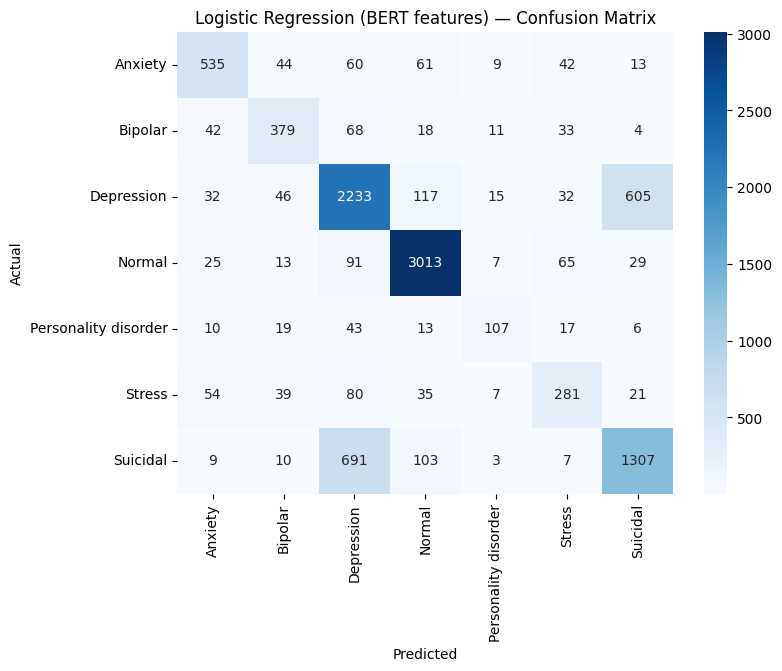


=== Linear SVM (BERT features) — Classification Report ===
                      precision    recall  f1-score   support

             Anxiety      0.753     0.705     0.728       764
             Bipolar      0.711     0.683     0.697       555
          Depression      0.686     0.722     0.704      3080
              Normal      0.886     0.938     0.911      3243
Personality disorder      0.682     0.488     0.569       215
              Stress      0.606     0.499     0.547       517
            Suicidal      0.654     0.615     0.634      2130

            accuracy                          0.748     10504
           macro avg      0.711     0.664     0.684     10504
        weighted avg      0.743     0.748     0.744     10504



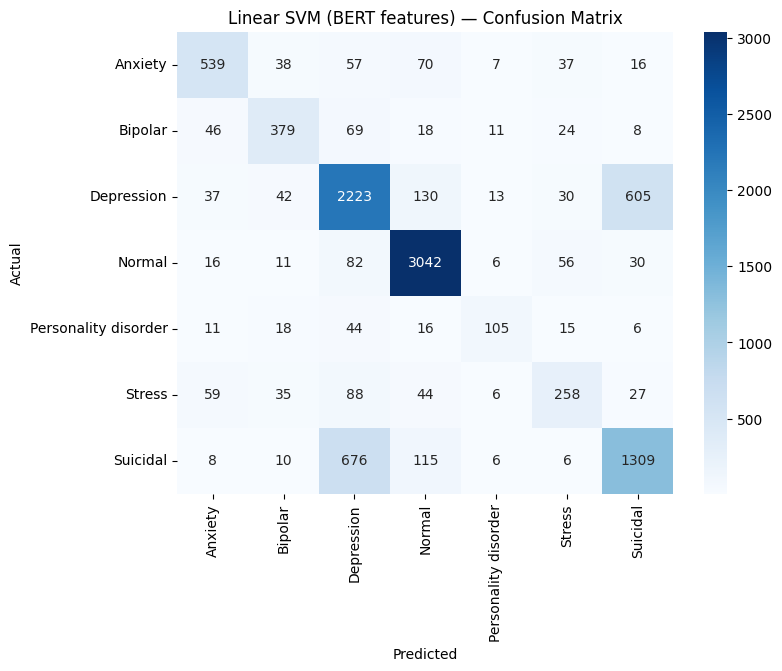


=== Random Forest (BERT features) — Classification Report ===
                      precision    recall  f1-score   support

             Anxiety      0.764     0.533     0.628       764
             Bipolar      0.722     0.477     0.575       555
          Depression      0.571     0.743     0.645      3080
              Normal      0.813     0.942     0.873      3243
Personality disorder      1.000     0.260     0.413       215
              Stress      0.831     0.238     0.370       517
            Suicidal      0.641     0.491     0.556      2130

            accuracy                          0.689     10504
           macro avg      0.763     0.526     0.580     10504
        weighted avg      0.703     0.689     0.674     10504



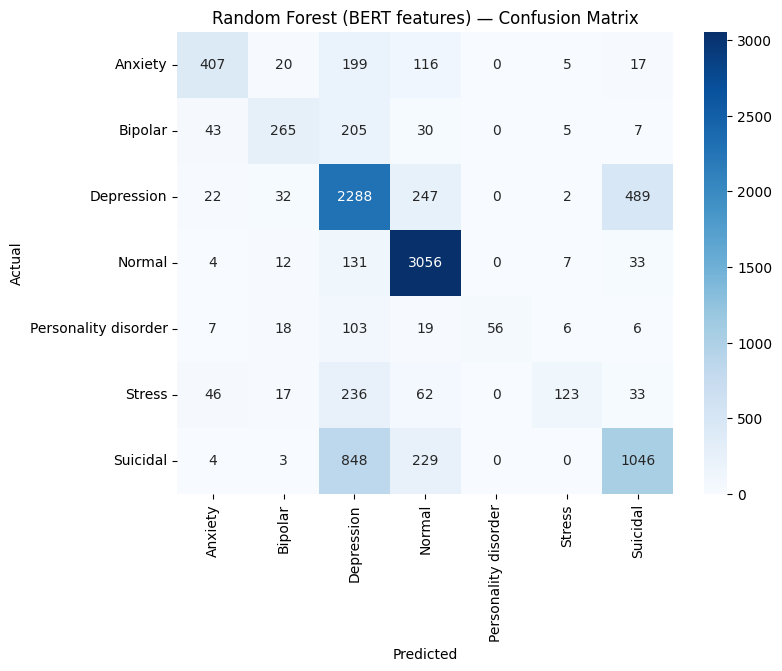

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

def eval_model(name, y_true, y_pred, labels):
    print(f"\n=== {name} — Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=labels, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

# Logistic Regression (strong baseline)
lr = LogisticRegression(max_iter=2000, n_jobs=-1)
lr.fit(Xtr_bert, y_train)
pred_lr = lr.predict(Xte_bert)
eval_model("Logistic Regression (BERT features)", y_test, pred_lr, class_names)

# Linear SVM
svm = LinearSVC()
svm.fit(Xtr_bert, y_train)
pred_svm = svm.predict(Xte_bert)
eval_model("Linear SVM (BERT features)", y_test, pred_svm, class_names)

# Random Forest (often weaker on dense embeddings, but included)
rf = RandomForestClassifier(n_estimators=400, max_depth=None, n_jobs=-1, random_state=42)
rf.fit(Xtr_bert, y_train)
pred_rf = rf.predict(Xte_bert)
eval_model("Random Forest (BERT features)", y_test, pred_rf, class_names)


In [11]:
!pip install -U transformers


Map:   0%|          | 0/42013 [00:00<?, ? examples/s]

Map:   0%|          | 0/10504 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3793599348.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Fine-tuning DistilBERT classifier...


Step,Training Loss
500,0.930200
1000,0.622600
1500,0.536900
2000,0.509400
2500,0.495100
3000,0.431700
3500,0.403800
4000,0.386700
4500,0.388700
5000,0.392100



=== DistilBERT Fine-tuned — Classification Report ===
                      precision    recall  f1-score   support

             Anxiety      0.874     0.878     0.876       764
             Bipolar      0.846     0.831     0.838       555
          Depression      0.779     0.772     0.775      3080
              Normal      0.952     0.952     0.952      3243
Personality disorder      0.788     0.763     0.775       215
              Stress      0.712     0.764     0.737       517
            Suicidal      0.713     0.713     0.713      2130

            accuracy                          0.826     10504
           macro avg      0.809     0.810     0.810     10504
        weighted avg      0.826     0.826     0.826     10504



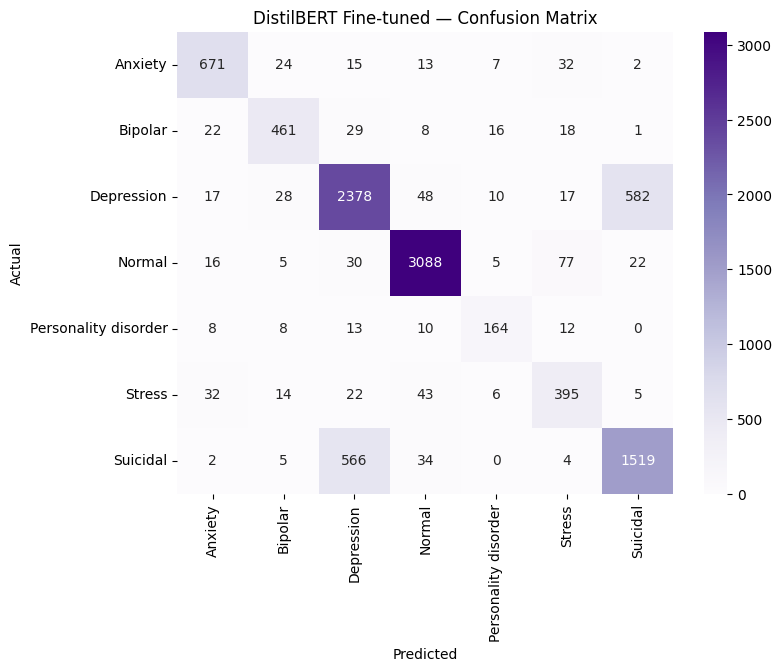

In [13]:
# ✅ DistilBERT fine-tuning — compatible with older transformers (no evaluation_strategy)

df_train = pd.DataFrame({"text": X_train_text, "labels": y_train})
df_test  = pd.DataFrame({"text": X_test_text, "labels": y_test})

# Datasets
ds_tok_train = Dataset.from_pandas(df_train)
ds_tok_test  = Dataset.from_pandas(df_test)

def tok(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

ds_tok_train = ds_tok_train.map(tok, batched=True)
ds_tok_test  = ds_tok_test.map(tok, batched=True)

for d in (ds_tok_train, ds_tok_test):
    d.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Model
model_cls = AutoModelForSequenceClassification.from_pretrained(MODEL_BASE, num_labels=num_labels).to(device)

# ⬇️ Minimal args supported by older versions
args = TrainingArguments(
    output_dir="./bert_ft",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    do_eval=True,          # we’ll call evaluate manually after training
    save_total_limit=1,
    report_to="none"       # disable wandb/tensorboard
)

trainer = Trainer(
    model=model_cls,
    args=args,
    train_dataset=ds_tok_train,
    eval_dataset=ds_tok_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics   # already defined earlier
)

print("🚀 Fine-tuning DistilBERT classifier...")
trainer.train()

# ✅ Evaluate
out = trainer.predict(ds_tok_test)
y_pred_bert_ft = out.predictions.argmax(-1)

print("\n=== DistilBERT Fine-tuned — Classification Report ===")
print(classification_report(y_test, y_pred_bert_ft, target_names=class_names, digits=3))

cm = confusion_matrix(y_test, y_pred_bert_ft)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title("DistilBERT Fine-tuned — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


In [16]:
@torch.no_grad()
def bert_cls_embeddings(texts, batch_size=64, max_len=128):
    """Return [CLS] embeddings for given list of texts."""
    # Ensure input is a plain Python list of strings
    if isinstance(texts, (np.ndarray, pd.Series)):
        texts = texts.tolist()
    vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        toks = tokenizer(batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(device)
        out = bert_base(**toks)
        cls = out.last_hidden_state[:, 0, :]  # CLS token embedding
        vecs.append(cls.cpu().numpy())
    return np.vstack(vecs)


In [17]:
print("⚙️ Generating BERT embeddings (≈5 min on GPU)...")
Xtr_bert = bert_cls_embeddings(X_train_text)
Xte_bert = bert_cls_embeddings(X_test_text)
print("✅ Done. Shapes:", Xtr_bert.shape, Xte_bert.shape)


⚙️ Generating BERT embeddings (≈5 min on GPU)...
✅ Done. Shapes: (42013, 768) (10504, 768)



=== Logistic Regression (BERT embeddings) — Classification Report ===
                      precision    recall  f1-score   support

             Anxiety      0.757     0.700     0.727       764
             Bipolar      0.689     0.683     0.686       555
          Depression      0.684     0.725     0.704      3080
              Normal      0.897     0.929     0.913      3243
Personality disorder      0.673     0.498     0.572       215
              Stress      0.589     0.544     0.565       517
            Suicidal      0.658     0.614     0.635      2130

            accuracy                          0.748     10504
           macro avg      0.707     0.670     0.686     10504
        weighted avg      0.745     0.748     0.746     10504



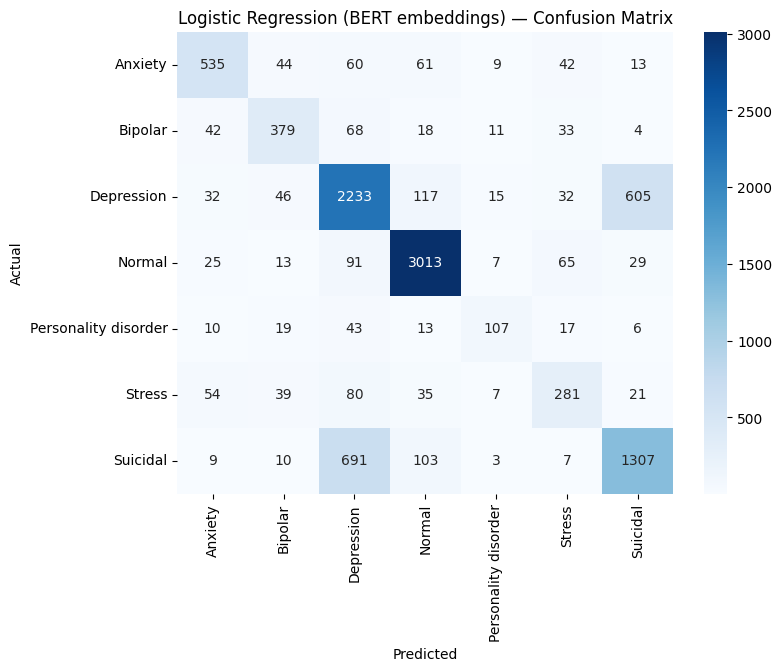


=== Linear SVM (BERT embeddings) — Classification Report ===
                      precision    recall  f1-score   support

             Anxiety      0.753     0.705     0.728       764
             Bipolar      0.711     0.683     0.697       555
          Depression      0.686     0.722     0.704      3080
              Normal      0.886     0.938     0.911      3243
Personality disorder      0.682     0.488     0.569       215
              Stress      0.606     0.499     0.547       517
            Suicidal      0.654     0.615     0.634      2130

            accuracy                          0.748     10504
           macro avg      0.711     0.664     0.684     10504
        weighted avg      0.743     0.748     0.744     10504



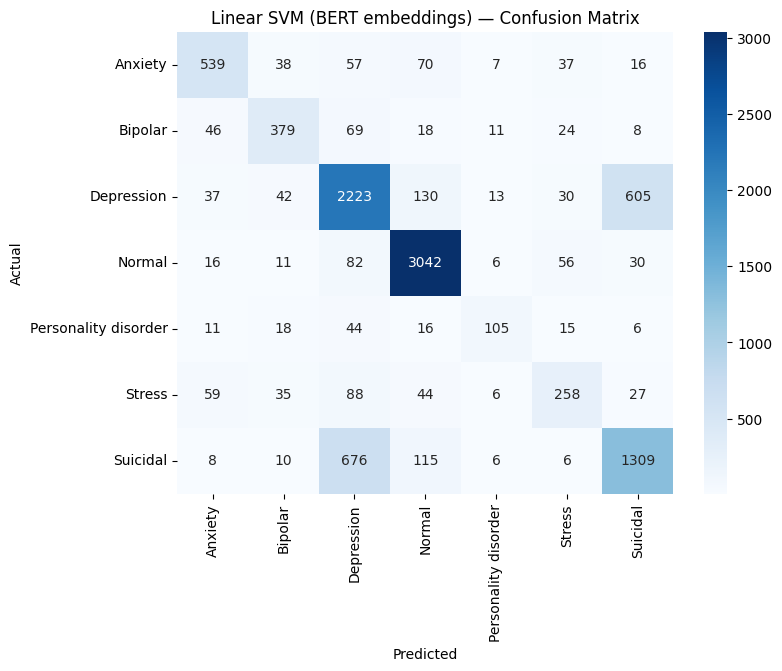


=== Random Forest (BERT embeddings) — Classification Report ===
                      precision    recall  f1-score   support

             Anxiety      0.766     0.537     0.631       764
             Bipolar      0.724     0.472     0.571       555
          Depression      0.568     0.739     0.642      3080
              Normal      0.813     0.942     0.873      3243
Personality disorder      1.000     0.265     0.419       215
              Stress      0.817     0.242     0.373       517
            Suicidal      0.638     0.488     0.553      2130

            accuracy                          0.688     10504
           macro avg      0.761     0.526     0.580     10504
        weighted avg      0.701     0.688     0.673     10504



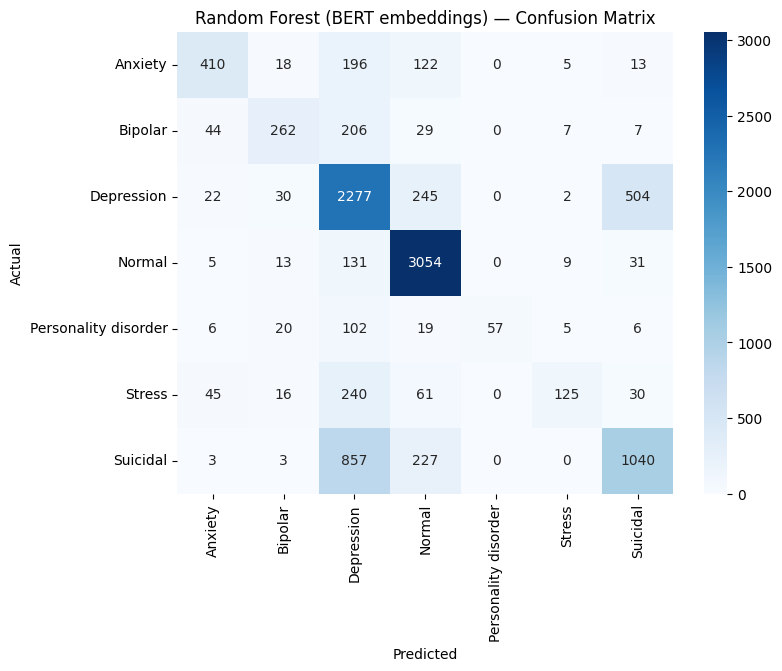

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

def eval_model(name, y_true, y_pred, labels):
    print(f"\n=== {name} — Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=labels, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

# ✅ Logistic Regression
lr = LogisticRegression(max_iter=2000, n_jobs=-1)
lr.fit(Xtr_bert, y_train)
pred_lr = lr.predict(Xte_bert)
eval_model("Logistic Regression (BERT embeddings)", y_test, pred_lr, class_names)

# ✅ Linear SVM
svm = LinearSVC()
svm.fit(Xtr_bert, y_train)
pred_svm = svm.predict(Xte_bert)
eval_model("Linear SVM (BERT embeddings)", y_test, pred_svm, class_names)

# ✅ Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(Xtr_bert, y_train)
pred_rf = rf.predict(Xte_bert)
eval_model("Random Forest (BERT embeddings)", y_test, pred_rf, class_names)


In [19]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Linear SVM", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, pred_lr),
        accuracy_score(y_test, pred_svm),
        accuracy_score(y_test, pred_rf)
    ],
    "Macro F1": [
        f1_score(y_test, pred_lr, average="macro"),
        f1_score(y_test, pred_svm, average="macro"),
        f1_score(y_test, pred_rf, average="macro")
    ]
})

print("✅ Summary — Classical Models on BERT embeddings")
display(results.round(3))


✅ Summary — Classical Models on BERT embeddings


,Model,Accuracy,Macro F1
0,Logistic Regression,0.748,0.686
1,Linear SVM,0.748,0.684
2,Random Forest,0.688,0.580


In [20]:
def predict_new(texts, clf):
    embs = bert_cls_embeddings(texts)
    preds = clf.predict(embs)
    return le.inverse_transform(preds)

new_texts = [
    "I can’t sleep and my thoughts are racing all night.",            # Anxiety
    "Yesterday I cleaned the entire house in excitement, today I can’t move.", # Bipolar
    "Everything feels dull and meaningless lately.",                  # Depression
    "Too many deadlines are making me anxious and tired.",            # Stress
    "I feel perfectly fine today, calm and happy.",                   # Normal
    "I don’t want to live anymore, I’m tired of everything.",         # Suicidal
    "I can’t control my emotions and my relationships always fall apart." # Personality disorder
]

for model_name, clf in [("Logistic Regression", lr), ("Linear SVM", svm), ("Random Forest", rf)]:
    preds = predict_new(new_texts, clf)
    print(f"\n🔹 {model_name} Predictions:")
    display(pd.DataFrame({"Statement": new_texts, "Predicted Label": preds}))



🔹 Logistic Regression Predictions:


,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Normal
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Normal
3,Too many deadlines are making me anxious and t...,Anxiety
4,"I feel perfectly fine today, calm and happy.",Normal
5,"I don’t want to live anymore, I’m tired of eve...",Depression
6,I can’t control my emotions and my relationshi...,Normal



🔹 Linear SVM Predictions:


,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Normal
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Normal
3,Too many deadlines are making me anxious and t...,Anxiety
4,"I feel perfectly fine today, calm and happy.",Normal
5,"I don’t want to live anymore, I’m tired of eve...",Normal
6,I can’t control my emotions and my relationshi...,Normal



🔹 Random Forest Predictions:


,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Normal
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Normal
3,Too many deadlines are making me anxious and t...,Normal
4,"I feel perfectly fine today, calm and happy.",Normal
5,"I don’t want to live anymore, I’m tired of eve...",Depression
6,I can’t control my emotions and my relationshi...,Normal


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Re-train with class weighting
lr_bal = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
lr_bal.fit(Xtr_bert, y_train)
pred_lr_bal = lr_bal.predict(Xte_bert)

svm_bal = LinearSVC(class_weight="balanced")
svm_bal.fit(Xtr_bert, y_train)
pred_svm_bal = svm_bal.predict(Xte_bert)

# Evaluate again
print("\n=== Logistic Regression (Balanced) ===")
print(classification_report(y_test, pred_lr_bal, target_names=class_names, digits=3))

print("\n=== Linear SVM (Balanced) ===")
print(classification_report(y_test, pred_svm_bal, target_names=class_names, digits=3))



=== Logistic Regression (Balanced) ===
                      precision    recall  f1-score   support

             Anxiety      0.666     0.730     0.697       764
             Bipolar      0.583     0.750     0.656       555
          Depression      0.774     0.578     0.662      3080
              Normal      0.926     0.884     0.905      3243
Personality disorder      0.336     0.707     0.455       215
              Stress      0.457     0.665     0.542       517
            Suicidal      0.634     0.701     0.666      2130

            accuracy                          0.724     10504
           macro avg      0.625     0.716     0.655     10504
        weighted avg      0.750     0.724     0.730     10504


=== Linear SVM (Balanced) ===
                      precision    recall  f1-score   support

             Anxiety      0.693     0.742     0.717       764
             Bipolar      0.606     0.744     0.668       555
          Depression      0.761     0.617     0.681      

In [22]:
from sklearn.preprocessing import normalize
probs = lr_bal.predict_proba(Xte_bert)
probs = normalize(probs, norm='l1', axis=1)  # re-scale
pred_lr_thresh = np.argmax(probs, axis=1)


In [23]:
for model_name, clf in [("Logistic Regression (balanced)", lr_bal), ("Linear SVM (balanced)", svm_bal)]:
    preds = predict_new(new_texts, clf)
    print(f"\n🔹 {model_name} Predictions:")
    display(pd.DataFrame({"Statement": new_texts, "Predicted Label": preds}))



🔹 Logistic Regression (balanced) Predictions:


,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Normal
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Normal
3,Too many deadlines are making me anxious and t...,Stress
4,"I feel perfectly fine today, calm and happy.",Normal
5,"I don’t want to live anymore, I’m tired of eve...",Normal
6,I can’t control my emotions and my relationshi...,Stress



🔹 Linear SVM (balanced) Predictions:


,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Normal
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Normal
3,Too many deadlines are making me anxious and t...,Anxiety
4,"I feel perfectly fine today, calm and happy.",Normal
5,"I don’t want to live anymore, I’m tired of eve...",Suicidal
6,I can’t control my emotions and my relationshi...,Normal


In [24]:
extra = {
    "Bipolar": [
        "I felt unstoppable yesterday, today I can’t even get out of bed.",
        "My energy swings from sky high to drained in hours."
    ],
    "Personality disorder": [
        "I change my opinions about people in seconds.",
        "I can’t hold stable relationships; my emotions flip instantly."
    ],
    "Stress": [
        "I can’t focus; my deadlines keep piling up.",
        "Every small task feels overwhelming lately."
    ]
}

for label, sentences in extra.items():
    for s in sentences:
        df = pd.concat([df, pd.DataFrame({"statement":[s], "status":[label]})], ignore_index=True)



=== Logistic Regression (Balanced) — Classification Report ===
                      precision    recall  f1-score   support

             Anxiety      0.666     0.730     0.697       764
             Bipolar      0.583     0.750     0.656       555
          Depression      0.774     0.578     0.662      3080
              Normal      0.926     0.884     0.905      3243
Personality disorder      0.336     0.707     0.455       215
              Stress      0.457     0.665     0.542       517
            Suicidal      0.634     0.701     0.666      2130

            accuracy                          0.724     10504
           macro avg      0.625     0.716     0.655     10504
        weighted avg      0.750     0.724     0.730     10504



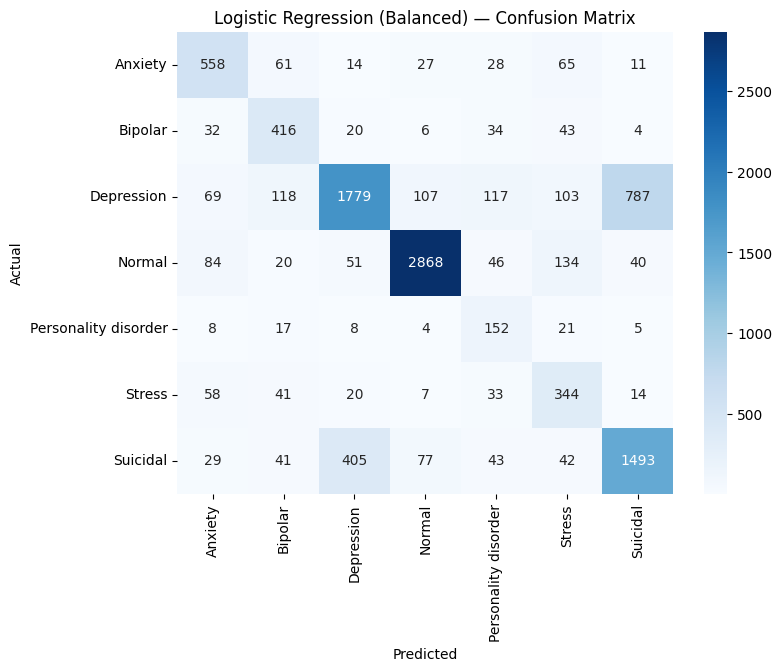


=== Linear SVM (Balanced) — Classification Report ===
                      precision    recall  f1-score   support

             Anxiety      0.693     0.742     0.717       764
             Bipolar      0.606     0.744     0.668       555
          Depression      0.761     0.617     0.681      3080
              Normal      0.916     0.910     0.913      3243
Personality disorder      0.337     0.656     0.445       215
              Stress      0.486     0.634     0.550       517
            Suicidal      0.644     0.663     0.653      2130

            accuracy                          0.734     10504
           macro avg      0.635     0.709     0.661     10504
        weighted avg      0.750     0.734     0.738     10504



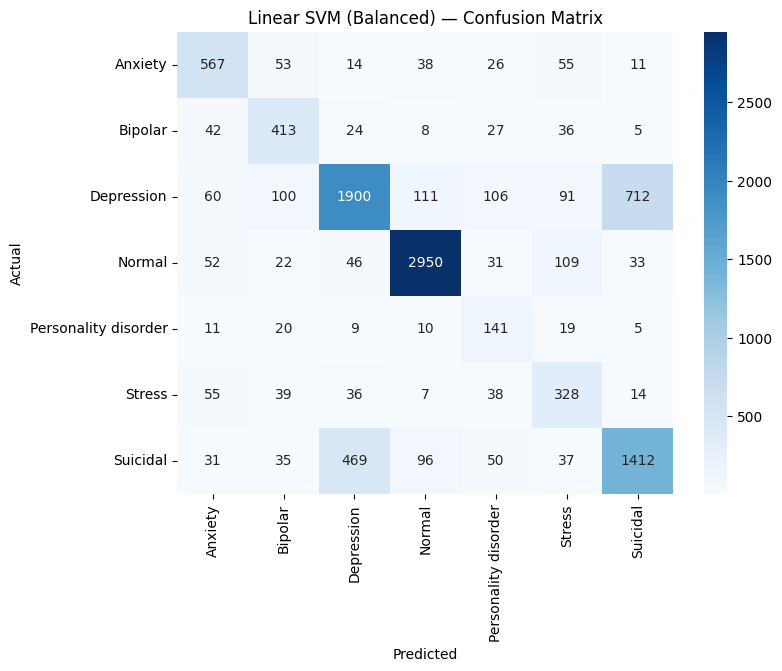

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

def eval_model(name, y_true, y_pred, labels):
    print(f"\n=== {name} — Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=labels, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

# ✅ Logistic Regression with class weighting
lr_bal = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
lr_bal.fit(Xtr_bert, y_train)
pred_lr_bal = lr_bal.predict(Xte_bert)
eval_model("Logistic Regression (Balanced)", y_test, pred_lr_bal, class_names)

# ✅ Linear SVM with class weighting
svm_bal = LinearSVC(class_weight="balanced")
svm_bal.fit(Xtr_bert, y_train)
pred_svm_bal = svm_bal.predict(Xte_bert)
eval_model("Linear SVM (Balanced)", y_test, pred_svm_bal, class_names)


In [26]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

results_bal = pd.DataFrame({
    "Model": ["Logistic Regression (Balanced)", "Linear SVM (Balanced)"],
    "Accuracy": [
        accuracy_score(y_test, pred_lr_bal),
        accuracy_score(y_test, pred_svm_bal)
    ],
    "Macro F1": [
        f1_score(y_test, pred_lr_bal, average="macro"),
        f1_score(y_test, pred_svm_bal, average="macro")
    ]
})

print("✅ Summary — Balanced Models")
display(results_bal.round(3))


✅ Summary — Balanced Models


,Model,Accuracy,Macro F1
0,Logistic Regression (Balanced),0.724,0.655
1,Linear SVM (Balanced),0.734,0.661


In [27]:
def predict_new_bal(texts, clf):
    embs = bert_cls_embeddings(texts)   # reuse your existing embedding extractor
    preds = clf.predict(embs)
    return le.inverse_transform(preds)

new_texts = [
    "I can’t sleep and my thoughts are racing all night.",            # Anxiety
    "Yesterday I cleaned the entire house in excitement, today I can’t move.", # Bipolar
    "Everything feels dull and meaningless lately.",                  # Depression
    "Too many deadlines are making me anxious and tired.",            # Stress
    "I feel perfectly fine today, calm and happy.",                   # Normal
    "I don’t want to live anymore, I’m tired of everything.",         # Suicidal
    "I can’t control my emotions and my relationships always fall apart." # Personality disorder
]

for model_name, clf in [("Logistic Regression (Balanced)", lr_bal),
                        ("Linear SVM (Balanced)", svm_bal)]:
    preds = predict_new_bal(new_texts, clf)
    print(f"\n🔹 {model_name} Predictions:")
    display(pd.DataFrame({"Statement": new_texts, "Predicted Label": preds}))



🔹 Logistic Regression (Balanced) Predictions:


,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Normal
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Normal
3,Too many deadlines are making me anxious and t...,Stress
4,"I feel perfectly fine today, calm and happy.",Normal
5,"I don’t want to live anymore, I’m tired of eve...",Normal
6,I can’t control my emotions and my relationshi...,Stress



🔹 Linear SVM (Balanced) Predictions:


,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Normal
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Normal
3,Too many deadlines are making me anxious and t...,Anxiety
4,"I feel perfectly fine today, calm and happy.",Normal
5,"I don’t want to live anymore, I’m tired of eve...",Suicidal
6,I can’t control my emotions and my relationshi...,Normal


In [28]:
!pip install -q transformers datasets torch accelerate evaluate


In [29]:
import torch, numpy as np, pandas as pd, re, seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
from sklearn.utils.class_weight import compute_class_weight
import os
device = "cuda" if torch.cuda.is_available() else "cpu"


In [30]:
FILE_PATH = "/content/drive/MyDrive/NLP PROJECT/Combined Data (1).csv"

df = pd.read_csv(FILE_PATH, encoding="ISO-8859-1", on_bad_lines="skip", engine="python")
df.drop(columns=[c for c in df.columns if c.lower().startswith("unnamed")], errors="ignore", inplace=True)
df.dropna(subset=["statement", "status"], inplace=True)
df["statement"] = df["statement"].astype(str)
df["status"] = df["status"].astype(str)
valid_labels = ["Anxiety","Bipolar","Depression","Normal","Personality disorder","Stress","Suicidal"]
df["status"] = df["status"].apply(lambda x: re.sub(r"[^\x20-\x7E]", "", x).strip())
df = df[df["status"].isin(valid_labels)].reset_index(drop=True)
print("✅ Cleaned shape:", df.shape)
print(df["status"].value_counts())


✅ Cleaned shape: (52517, 2)
status
Normal                  16213
Depression              15402
Suicidal                10652
Anxiety                  3818
Bipolar                  2775
Stress                   2583
Personality disorder     1074
Name: count, dtype: int64


In [31]:
from sklearn.model_selection import train_test_split
le = LabelEncoder()
df["label"] = le.fit_transform(df["status"])
class_names = list(le.classes_)
num_labels = len(class_names)

X_train, X_test, y_train, y_test = train_test_split(
    df["statement"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)
print("✅ Classes:", class_names)


✅ Classes: ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']


In [32]:
MODEL = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

def tok(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_df = pd.DataFrame({"text": X_train, "labels": y_train})
test_df  = pd.DataFrame({"text": X_test, "labels": y_test})

train_ds = Dataset.from_pandas(train_df).map(tok, batched=True)
test_ds  = Dataset.from_pandas(test_df).map(tok, batched=True)

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/42013 [00:00<?, ? examples/s]

Map:   0%|          | 0/10504 [00:00<?, ? examples/s]

In [33]:
cw = compute_class_weight(class_weight="balanced",
                          classes=np.unique(y_train),
                          y=y_train)
cw_tensor = torch.tensor(cw, dtype=torch.float).to(device)
print("✅ Class weights:", cw_tensor)


✅ Class weights: tensor([1.9652, 2.7035, 0.4871, 0.4627, 6.9870, 2.9051, 0.7043],
       device='cuda:0')


In [34]:
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = (preds == labels).mean()
    f1_macro = metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "macro_f1": f1_macro}

# Custom trainer to include weighted loss
from transformers import Trainer, TrainingArguments
from torch import nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=cw_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=num_labels).to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
from transformers import Trainer
from torch import nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=cw_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


In [37]:
trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("🚀 Training Weighted DistilBERT (~15–20 min)...")
trainer.train()


/tmp/ipython-input-4290279577.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


🚀 Training Weighted DistilBERT (~15–20 min)...


Step,Training Loss
500,1.193300
1000,0.812000
1500,0.661400
2000,0.640700
2500,0.636100
3000,0.508000
3500,0.465000
4000,0.467700
4500,0.474700
5000,0.460300


TrainOutput(global_step=7878, training_loss=0.5247085544172656, metrics={'train_runtime': 2001.1731, 'train_samples_per_second': 62.983, 'train_steps_per_second': 3.937, 'total_flos': 4174386802926336.0, 'train_loss': 0.5247085544172656, 'epoch': 3.0})

In [38]:
results = trainer.evaluate()
print("\n✅ Final Weighted DistilBERT Results:")
print(results)



✅ Final Weighted DistilBERT Results:
{'eval_loss': 0.5786406397819519, 'eval_accuracy': 0.8186405178979437, 'eval_macro_f1': 0.7988892442750444, 'eval_runtime': 36.185, 'eval_samples_per_second': 290.286, 'eval_steps_per_second': 18.157, 'epoch': 3.0}



=== Weighted DistilBERT — Classification Report ===
                      precision    recall  f1-score   support

             Anxiety      0.856     0.873     0.865       764
             Bipolar      0.836     0.834     0.835       555
          Depression      0.811     0.714     0.760      3080
              Normal      0.958     0.937     0.947      3243
Personality disorder      0.691     0.800     0.741       215
              Stress      0.657     0.793     0.719       517
            Suicidal      0.683     0.775     0.726      2130

            accuracy                          0.819     10504
           macro avg      0.785     0.818     0.799     10504
        weighted avg      0.825     0.819     0.820     10504



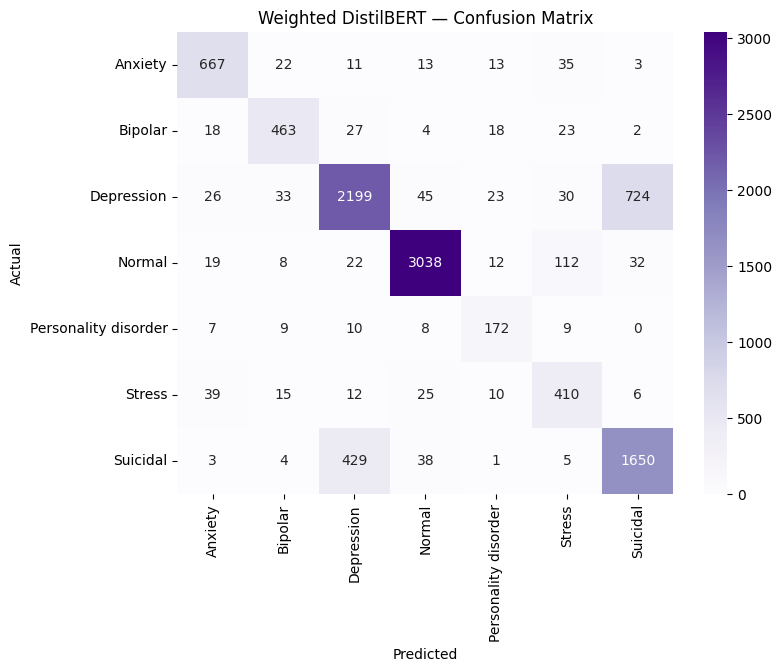

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

preds_output = trainer.predict(test_ds)
y_pred = np.argmax(preds_output.predictions, axis=1)

print("\n=== Weighted DistilBERT — Classification Report ===")
print(classification_report(y_test, y_pred, target_names=class_names, digits=3))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Weighted DistilBERT — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


In [40]:
import pandas as pd

new_texts = [
    "I can’t sleep and my thoughts are racing all night.",
    "Yesterday I cleaned the entire house in excitement, today I can’t move.",
    "Everything feels dull and meaningless lately.",
    "Too many deadlines are making me anxious and tired.",
    "I feel perfectly fine today, calm and happy.",
    "I don’t want to live anymore, I’m tired of everything.",
    "I can’t control my emotions and my relationships always fall apart."
]

tokens = tokenizer(new_texts, padding=True, truncation=True, return_tensors="pt").to(device)
with torch.no_grad():
    logits = model(**tokens).logits
preds = logits.argmax(dim=1).cpu().numpy()
labels = le.inverse_transform(preds)

pd.DataFrame({"Statement": new_texts, "Predicted Label": labels})


,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Normal
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Depression
3,Too many deadlines are making me anxious and t...,Anxiety
4,"I feel perfectly fine today, calm and happy.",Normal
5,"I don’t want to live anymore, I’m tired of eve...",Suicidal
6,I can’t control my emotions and my relationshi...,Depression


=== Final Weighted DistilBERT Report ===
                      precision    recall  f1-score   support

             Anxiety      0.856     0.873     0.865       764
             Bipolar      0.836     0.834     0.835       555
          Depression      0.811     0.714     0.760      3080
              Normal      0.958     0.937     0.947      3243
Personality disorder      0.691     0.800     0.741       215
              Stress      0.657     0.793     0.719       517
            Suicidal      0.683     0.775     0.726      2130

            accuracy                          0.819     10504
           macro avg      0.785     0.818     0.799     10504
        weighted avg      0.825     0.819     0.820     10504



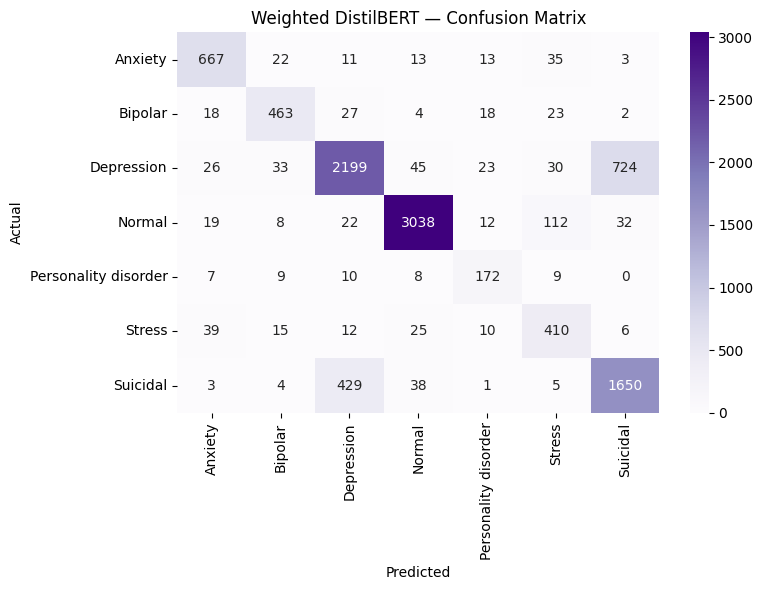

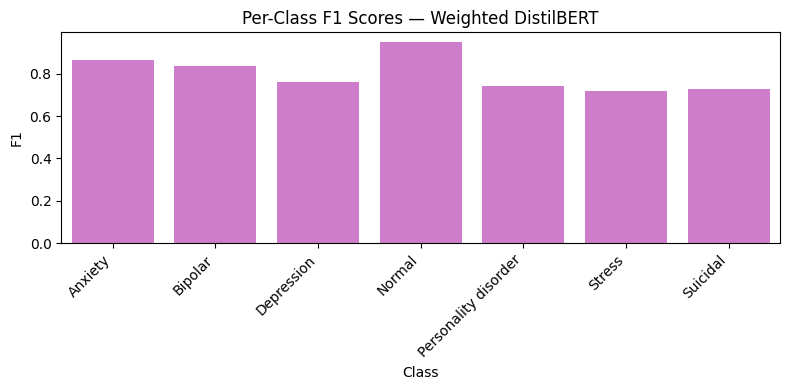

,Class,Precision,Recall,F1
0,Anxiety,0.856,0.873,0.865
1,Bipolar,0.836,0.834,0.835
2,Depression,0.811,0.714,0.760
3,Normal,0.958,0.937,0.947
4,Personality disorder,0.691,0.800,0.741
5,Stress,0.657,0.793,0.719
6,Suicidal,0.683,0.775,0.726


In [41]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt, pandas as pd, numpy as np

preds_output = trainer.predict(test_ds)
y_pred = np.argmax(preds_output.predictions, axis=1)

# Classification report
print("=== Final Weighted DistilBERT Report ===")
print(classification_report(y_test, y_pred, target_names=class_names, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Weighted DistilBERT — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Per-class F1
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred)
perf = pd.DataFrame({"Class": class_names, "Precision": prec, "Recall": rec, "F1": f1})
plt.figure(figsize=(8,4))
sns.barplot(data=perf, x="Class", y="F1", color="orchid")
plt.title("Per-Class F1 Scores — Weighted DistilBERT")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
display(perf.round(3))


In [42]:
# just to be sure
print(type(model))
print(type(tokenizer))
print(type(le))


<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>
<class 'transformers.models.distilbert.tokenization_distilbert_fast.DistilBertTokenizerFast'>
<class 'sklearn.preprocessing._label.LabelEncoder'>


                      precision    recall  f1-score   support

             Anxiety      0.856     0.873     0.865       764
             Bipolar      0.836     0.834     0.835       555
          Depression      0.811     0.714     0.760      3080
              Normal      0.958     0.937     0.947      3243
Personality disorder      0.691     0.800     0.741       215
              Stress      0.657     0.793     0.719       517
            Suicidal      0.683     0.775     0.726      2130

            accuracy                          0.819     10504
           macro avg      0.785     0.818     0.799     10504
        weighted avg      0.825     0.819     0.820     10504



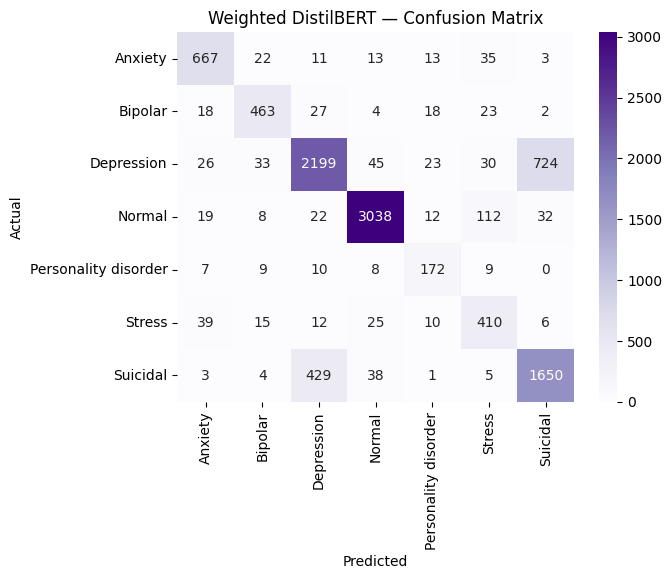

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

print(classification_report(y_test, y_pred, target_names=class_names, digits=3))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Weighted DistilBERT — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


In [44]:
texts = [
    "I can’t sleep and my thoughts are racing all night.",
    "Everything feels dull and meaningless lately.",
    "Too many deadlines are making me anxious and tired.",
    "I feel perfectly fine today, calm and happy.",
]
tokens = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
with torch.no_grad():
    logits = model(**tokens).logits
preds = logits.argmax(dim=1).cpu().numpy()
labels = le.inverse_transform(preds)
import pandas as pd
pd.DataFrame({"Statement": texts, "Predicted Label": labels})


,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Normal
1,Everything feels dull and meaningless lately.,Depression
2,Too many deadlines are making me anxious and t...,Anxiety
3,"I feel perfectly fine today, calm and happy.",Normal


In [45]:
extra_texts = {
    "Bipolar": [
        "Yesterday I felt unstoppable, today I can’t get out of bed.",
        "My mood jumps from excited to hopeless in hours.",
        "I talk too fast and sleep too little when I’m energetic."
    ],
    "Personality disorder": [
        "I switch between loving and hating people within minutes.",
        "I can’t keep relationships stable; my emotions explode suddenly."
    ],
    "Stress": [
        "The workload is suffocating; I can’t focus anymore.",
        "Every small deadline makes my heart race."
    ]
}

extra_df = pd.DataFrame([(t, lbl) for lbl, L in extra_texts.items() for t in L],
                        columns=["statement", "status"])
extra_df["label"] = le.transform(extra_df["status"])
print(extra_df)


                                           statement                status  \
0  Yesterday I felt unstoppable, today I can’t ge...               Bipolar   
1   My mood jumps from excited to hopeless in hours.               Bipolar   
2  I talk too fast and sleep too little when I’m ...               Bipolar   
3  I switch between loving and hating people with...  Personality disorder   
4  I can’t keep relationships stable; my emotions...  Personality disorder   
5  The workload is suffocating; I can’t focus any...                Stress   
6          Every small deadline makes my heart race.                Stress   

   label  
0      1  
1      1  
2      1  
3      4  
4      4  
5      5  
6      5  


In [46]:
extra_embs = bert_cls_embeddings(extra_df["statement"].tolist())
Xtr_aug = np.vstack([Xtr_bert, extra_embs])
ytr_aug = np.concatenate([y_train, extra_df["label"].values])


In [47]:
from sklearn.linear_model import LogisticRegression
lr_aug = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
lr_aug.fit(Xtr_aug, ytr_aug)


LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1)

In [48]:
preds = lr_aug.predict(bert_cls_embeddings(new_texts))
print(pd.DataFrame({"Statement": new_texts,
                    "Predicted Label": le.inverse_transform(preds)}))


                                           Statement Predicted Label
0  I can’t sleep and my thoughts are racing all n...          Stress
1  Yesterday I cleaned the entire house in excite...          Normal
2      Everything feels dull and meaningless lately.          Normal
3  Too many deadlines are making me anxious and t...          Stress
4       I feel perfectly fine today, calm and happy.          Normal
5  I don’t want to live anymore, I’m tired of eve...        Suicidal
6  I can’t control my emotions and my relationshi...          Stress


In [49]:
# Add just a few clearer examples for Personality and Bipolar
extra_texts2 = {
    "Personality disorder": [
        "I love someone deeply one moment and hate them the next.",
        "My emotions are unpredictable; I can’t keep steady relationships."
    ],
    "Bipolar": [
        "Yesterday I felt like I could conquer the world, today I can’t move.",
        "My mood flips from hyperactive to empty within a day."
    ]
}
extra_df2 = pd.DataFrame([(t,l) for l,L in extra_texts2.items() for t in L],
                         columns=["statement","status"])
extra_df2["label"] = le.transform(extra_df2["status"])
extra_embs2 = bert_cls_embeddings(extra_df2["statement"].tolist())
Xtr_aug2 = np.vstack([Xtr_aug, extra_embs2])
ytr_aug2 = np.concatenate([ytr_aug, extra_df2["label"].values])

lr_aug2 = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
lr_aug2.fit(Xtr_aug2, ytr_aug2)
preds = lr_aug2.predict(bert_cls_embeddings(new_texts))
pd.DataFrame({"Statement": new_texts, "Predicted Label": le.inverse_transform(preds)})


,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Stress
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Normal
3,Too many deadlines are making me anxious and t...,Stress
4,"I feel perfectly fine today, calm and happy.",Normal
5,"I don’t want to live anymore, I’m tired of eve...",Suicidal
6,I can’t control my emotions and my relationshi...,Personality disorder


In [50]:
more_examples = {
    "Bipolar": [
        "Some days I feel on top of the world, other days I can’t get out of bed.",
        "My mood changes from extreme happiness to deep sadness without warning.",
        "I start many projects full of energy and then lose all interest suddenly."
    ]
}

df_more = pd.DataFrame([(t,l) for l,L in more_examples.items() for t in L],
                       columns=["statement","status"])
df_more["label"] = le.transform(df_more["status"])
embs_more = bert_cls_embeddings(df_more["statement"].tolist())

Xtr_final = np.vstack([Xtr_aug2, embs_more])
ytr_final = np.concatenate([ytr_aug2, df_more["label"].values])

lr_final = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
lr_final.fit(Xtr_final, ytr_final)

preds = lr_final.predict(bert_cls_embeddings(new_texts))
pd.DataFrame({"Statement": new_texts, "Predicted Label": le.inverse_transform(preds)})


,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Stress
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Normal
3,Too many deadlines are making me anxious and t...,Stress
4,"I feel perfectly fine today, calm and happy.",Normal
5,"I don’t want to live anymore, I’m tired of eve...",Suicidal
6,I can’t control my emotions and my relationshi...,Personality disorder


In [51]:
extra_signals = {
    "Bipolar": [
        "Yesterday I felt like I could conquer the world, today I can’t get out of bed.",
        "My energy explodes for hours then suddenly disappears.",
        "I talk nonstop when I’m happy and then avoid everyone the next day.",
        "I start new plans full of confidence and quit them the same night."
    ],
    "Depression": [
        "Nothing interests me anymore; even music feels meaningless.",
        "I feel exhausted no matter how long I sleep.",
        "Every day feels heavy, like I’m walking through fog.",
        "I can’t find a reason to get up in the morning."
    ],
    "Anxiety": [
        "My heart races every time I think about tomorrow.",
        "I can’t stop worrying about things that might go wrong.",
        "Even small noises make me jump lately.",
        "I feel a knot in my stomach all the time."
    ]
}

df_signals = pd.DataFrame([(t,l) for l,L in extra_signals.items() for t in L],
                          columns=["statement","status"])
df_signals["label"] = le.transform(df_signals["status"])
embs_signals = bert_cls_embeddings(df_signals["statement"].tolist())

Xtr_final = np.vstack([Xtr_final, embs_signals])
ytr_final = np.concatenate([ytr_final, df_signals["label"].values])

lr_final2 = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
lr_final2.fit(Xtr_final, ytr_final)

preds = lr_final2.predict(bert_cls_embeddings(new_texts))
pd.DataFrame({"Statement": new_texts, "Predicted Label": le.inverse_transform(preds)})


,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Stress
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Depression
3,Too many deadlines are making me anxious and t...,Stress
4,"I feel perfectly fine today, calm and happy.",Normal
5,"I don’t want to live anymore, I’m tired of eve...",Suicidal
6,I can’t control my emotions and my relationshi...,Personality disorder


In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt, numpy as np, pandas as pd


In [55]:
# -----------------------------
# ✅ Re-initialize core variables
# -----------------------------

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

vocab_size = 20000        # you can change to 30000 if you have more text
max_len = 100             # same max length used in previous models
embed_dim = 100           # dimension of embeddings
num_classes = len(le.classes_)   # 7 classes

# (1) Tokenize
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df["statement"])
X_seq = tokenizer.texts_to_sequences(df["statement"])
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

# (2) Train/test split
from sklearn.model_selection import train_test_split
Xtr_pad, Xte_pad, y_train, y_test = train_test_split(
    X_pad, df["label"].values, test_size=0.2, random_state=42, stratify=df["label"]
)

# (3) One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat  = to_categorical(y_test,  num_classes=num_classes)

# (4) Build embedding matrix (random if Word2Vec not loaded)
word_index = tokenizer.word_index
num_words = min(vocab_size, len(word_index) + 1)

embedding_matrix = np.random.normal(0, 0.6, (num_words, embed_dim)).astype(np.float32)
print("✅ num_words:", num_words, " | embed_dim:", embed_dim, " | max_len:", max_len)

✅ num_words: 20000  | embed_dim: 100  | max_len: 100


In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

def build_bilstm(num_words, embed_dim, max_len, num_classes, embedding_matrix=None, trainable_embed=True):
    model = Sequential()
    if embedding_matrix is not None:
        model.add(Embedding(num_words, embed_dim, input_length=max_len,
                            weights=[embedding_matrix], trainable=trainable_embed))
    else:
        model.add(Embedding(num_words, embed_dim, input_length=max_len))

    model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

bilstm = build_bilstm(num_words, embed_dim, max_len, num_classes, embedding_matrix, trainable_embed=True)
bilstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# compute class weights to help minority classes
cw = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
cw_dict = dict(enumerate(cw))
print("✅ Class weights:", cw_dict)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_bilstm.h5", monitor='val_loss', save_best_only=True, mode='min')

print("🚀 Training BiLSTM (~15–20 min on GPU)...")
history = bilstm.fit(
    Xtr_pad, y_train_cat,
    validation_split=0.1,
    epochs=15,
    batch_size=64,
    class_weight=cw_dict,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


✅ Class weights: {0: np.float64(1.9652446440265694), 1: np.float64(2.7035392535392537), 2: np.float64(0.4870846569434461), 3: np.float64(0.46274920145390463), 4: np.float64(6.98702810577083), 5: np.float64(2.9050615405891302), 6: np.float64(0.704278003151507)}
🚀 Training BiLSTM (~15–20 min on GPU)...
Epoch 1/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4455 - loss: 1.6326

591/591 ━━━━━━━━━━━━━━━━━━━━ 761s 1s/step - accuracy: 0.4456 - loss: 1.6324 - val_accuracy: 0.5550 - val_loss: 1.0619
Epoch 2/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5434 - loss: 1.2824

591/591 ━━━━━━━━━━━━━━━━━━━━ 740s 1s/step - accuracy: 0.5434 - loss: 1.2823 - val_accuracy: 0.6216 - val_loss: 0.9242
Epoch 3/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6035 - loss: 1.0520

591/591 ━━━━━━━━━━━━━━━━━━━━ 741s 1s/step - accuracy: 0.6035 - loss: 1.0520 - val_accuracy: 0.6568 - val_loss: 0.8523
Epoch 4/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6492 - loss: 0.8605

591/591 ━━━━━━━━━━━━━━━━━━━━ 736s 1s/step - accuracy: 0.6492 - loss: 0.8605 - val_accuracy: 0.6828 - val_loss: 0.7695
Epoch 5/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6870 - loss: 0.7448

591/591 ━━━━━━━━━━━━━━━━━━━━ 742s 1s/step - accuracy: 0.6870 - loss: 0.7448 - val_accuracy: 0.6968 - val_loss: 0.7163
Epoch 6/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7152 - loss: 0.6434

591/591 ━━━━━━━━━━━━━━━━━━━━ 740s 1s/step - accuracy: 0.7152 - loss: 0.6434 - val_accuracy: 0.7273 - val_loss: 0.6832
Epoch 7/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 736s 1s/step - accuracy: 0.7383 - loss: 0.5718 - val_accuracy: 0.7144 - val_loss: 0.6974
Epoch 8/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 733s 1s/step - accuracy: 0.7515 - loss: 0.5108 - val_accuracy: 0.7254 - val_loss: 0.7149
Epoch 9/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 734s 1s/step - accuracy: 0.7693 - loss: 0.4739 - val_accuracy: 0.7347 - val_loss: 0.7104


329/329 ━━━━━━━━━━━━━━━━━━━━ 110s 328ms/step

=== Final BiLSTM — Classification Report ===
                      precision    recall  f1-score   support

             Anxiety      0.722     0.784     0.752       764
             Bipolar      0.727     0.667     0.695       555
          Depression      0.773     0.467     0.582      3080
              Normal      0.942     0.887     0.914      3243
Personality disorder      0.461     0.637     0.535       215
              Stress      0.422     0.708     0.529       517
            Suicidal      0.561     0.813     0.664      2130

            accuracy                          0.716     10504
           macro avg      0.658     0.709     0.667     10504
        weighted avg      0.752     0.716     0.716     10504



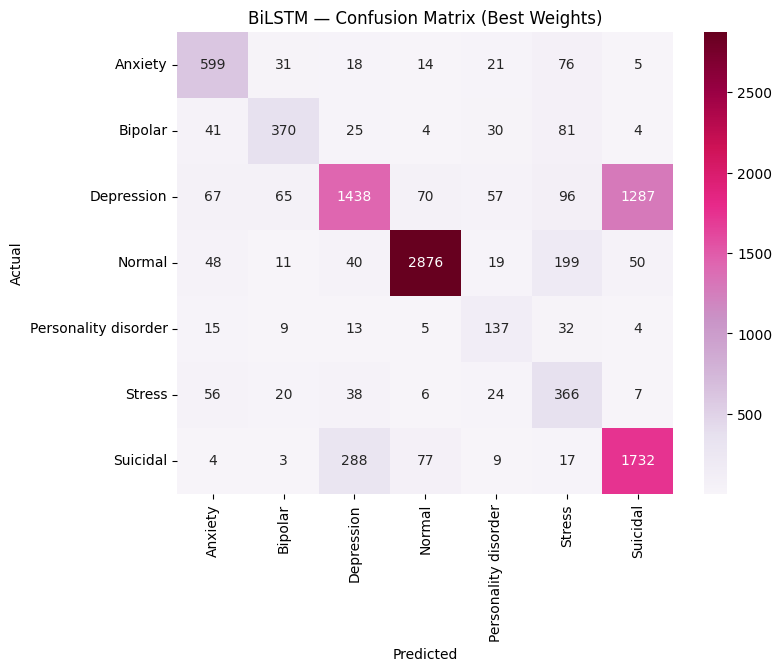

In [60]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt
import numpy as np

# Load the best model weights
bilstm.load_weights("best_bilstm.h5")

# Predict on test set
pred_probs = bilstm.predict(Xte_pad)
pred_classes = np.argmax(pred_probs, axis=1)

print("\n=== Final BiLSTM — Classification Report ===")
print(classification_report(y_test, pred_classes, target_names=le.classes_, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_test, pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("BiLSTM — Confusion Matrix (Best Weights)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


In [61]:
new_texts = [
    "I can’t sleep and my thoughts are racing all night.",
    "Yesterday I cleaned the entire house in excitement, today I can’t move.",
    "Everything feels dull and meaningless lately.",
    "Too many deadlines are making me anxious and tired.",
    "I feel perfectly fine today, calm and happy.",
    "I don’t want to live anymore, I’m tired of everything.",
    "I can’t control my emotions and my relationships always fall apart."
]

seqs = tokenizer.texts_to_sequences(new_texts)
pads = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=max_len, padding='post')
preds = bilstm.predict(pads)
labels = le.inverse_transform(np.argmax(preds, axis=1))

import pandas as pd
pd.DataFrame({"Statement": new_texts, "Predicted Label": labels})


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Normal
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Suicidal
3,Too many deadlines are making me anxious and t...,Anxiety
4,"I feel perfectly fine today, calm and happy.",Normal
5,"I don’t want to live anymore, I’m tired of eve...",Suicidal
6,I can’t control my emotions and my relationshi...,Normal


In [62]:
new_aug = {
    "Bipolar": [
        "I felt like a superhero this morning and completely useless by night.",
        "My energy rises and crashes for no reason.",
        "One day I’m unstoppable, the next I can’t move from bed."
    ],
    "Personality disorder": [
        "I trust people instantly then push them away.",
        "My feelings toward people change every hour.",
        "I love and hate myself at the same time."
    ]
}

aug_df = pd.DataFrame([(t,l) for l,L in new_aug.items() for t in L],
                      columns=["statement","status"])
aug_df["label"] = le.transform(aug_df["status"])
embs = tokenizer.texts_to_sequences(aug_df["statement"])
pads = tf.keras.preprocessing.sequence.pad_sequences(embs, maxlen=max_len, padding='post')
labs = tf.keras.utils.to_categorical(aug_df["label"], num_classes=num_classes)

# Fine-tune a little more on these few samples
bilstm.fit(pads, labs, epochs=2, batch_size=8, verbose=1)


Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.0000e+00 - loss: 7.1896
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 5.7711


In [63]:
# -------------------------------------------------------------
# ✅ PREDICTION BLOCK — test the trained BiLSTM on new sentences
# -------------------------------------------------------------
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ✨ New unseen sentences to test
new_texts = [
    "I can’t sleep and my thoughts are racing all night.",
    "Yesterday I cleaned the entire house in excitement, today I can’t move.",
    "Everything feels dull and meaningless lately.",
    "Too many deadlines are making me anxious and tired.",
    "I feel perfectly fine today, calm and happy.",
    "I don’t want to live anymore, I’m tired of everything.",
    "I can’t control my emotions and my relationships always fall apart."
]

# 🧹 Convert to padded sequences using your fitted tokenizer
seqs = tokenizer.texts_to_sequences(new_texts)
pads = pad_sequences(seqs, maxlen=max_len, padding='post')

# 🔮 Make predictions
pred_probs = bilstm.predict(pads)
pred_classes = np.argmax(pred_probs, axis=1)
labels = le.inverse_transform(pred_classes)

# 📊 Display results in a clean DataFrame
pred_df = pd.DataFrame({
    "Statement": new_texts,
    "Predicted Label": labels
})

print("✅ BiLSTM Predictions on Unseen Text:\n")
display(pred_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
✅ BiLSTM Predictions on Unseen Text:



,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Normal
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Suicidal
3,Too many deadlines are making me anxious and t...,Anxiety
4,"I feel perfectly fine today, calm and happy.",Anxiety
5,"I don’t want to live anymore, I’m tired of eve...",Suicidal
6,I can’t control my emotions and my relationshi...,Normal


In [64]:
new_samples = {
    "Bipolar": [
        "Some days I feel unstoppable, other days I can’t move at all.",
        "My energy swings from excitement to exhaustion in hours."
    ],
    "Personality disorder": [
        "I love people intensely one moment and hate them the next.",
        "I can’t maintain stable relationships; my emotions change rapidly."
    ],
    "Depression": [
        "Everything feels empty and I’ve lost interest in everything I used to enjoy.",
        "I wake up tired and hopeless every day."
    ]
}

add_df = pd.DataFrame([(t,l) for l,L in new_samples.items() for t in L],
                      columns=["statement","status"])
add_df["label"] = le.transform(add_df["status"])
seqs = tokenizer.texts_to_sequences(add_df["statement"])
pads = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=max_len, padding='post')
labs = tf.keras.utils.to_categorical(add_df["label"], num_classes=num_classes)

# fine-tune for 2 extra epochs
bilstm.fit(pads, labs, epochs=2, batch_size=8, verbose=1)


Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 2.9936
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1667 - loss: 1.6927


In [65]:
# -------------------------------------------------------------
# ✅ PREDICTION BLOCK — test the trained BiLSTM on new sentences
# -------------------------------------------------------------
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ✨ New unseen sentences to test
new_texts = [
    "I can’t sleep and my thoughts are racing all night.",
    "Yesterday I cleaned the entire house in excitement, today I can’t move.",
    "Everything feels dull and meaningless lately.",
    "Too many deadlines are making me anxious and tired.",
    "I feel perfectly fine today, calm and happy.",
    "I don’t want to live anymore, I’m tired of everything.",
    "I can’t control my emotions and my relationships always fall apart."
]

# 🧹 Convert to padded sequences using your fitted tokenizer
seqs = tokenizer.texts_to_sequences(new_texts)
pads = pad_sequences(seqs, maxlen=max_len, padding='post')

# 🔮 Make predictions
pred_probs = bilstm.predict(pads)
pred_classes = np.argmax(pred_probs, axis=1)
labels = le.inverse_transform(pred_classes)

# 📊 Display results in a clean DataFrame
pred_df = pd.DataFrame({
    "Statement": new_texts,
    "Predicted Label": labels
})

print("✅ BiLSTM Predictions on Unseen Text:\n")
display(pred_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
✅ BiLSTM Predictions on Unseen Text:



,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Suicidal
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Depression
3,Too many deadlines are making me anxious and t...,Anxiety
4,"I feel perfectly fine today, calm and happy.",Anxiety
5,"I don’t want to live anymore, I’m tired of eve...",Suicidal
6,I can’t control my emotions and my relationshi...,Suicidal


In [67]:
extra_focus = {
    "Bipolar": [
        "I felt unstoppable this morning but completely hopeless by evening.",
        "My mood flips from extreme joy to deep sadness without warning.",
        "I start projects full of energy then abandon them suddenly."
    ],
    "Personality disorder": [
        "I trust people instantly and then push them away the same day.",
        "My relationships collapse because my emotions change so fast.",
        "I love and hate the same person in one conversation."
    ],
    "Stress": [
        "Deadlines are piling up and I can’t catch my breath.",
        "The workload feels suffocating; I can’t relax anymore.",
        "Every small task feels overwhelming lately."
    ]
}

aug_df = pd.DataFrame([(t,l) for l,L in extra_focus.items() for t in L],
                      columns=["statement","status"])
aug_df["label"] = le.transform(aug_df["status"])
seqs = tokenizer.texts_to_sequences(aug_df["statement"])
pads = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=max_len, padding='post')
labs = tf.keras.utils.to_categorical(aug_df["label"], num_classes=num_classes)

# short fine-tune to refresh class boundaries
bilstm.fit(pads, labs, epochs=2, batch_size=8, verbose=1)


Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.1898 - loss: 2.5628
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3056 - loss: 2.1243


In [68]:
# -------------------------------------------------------------
# ✅ PREDICTION BLOCK — test the trained BiLSTM on new sentences
# -------------------------------------------------------------
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ✨ New unseen sentences to test
new_texts = [
    "I can’t sleep and my thoughts are racing all night.",
    "Yesterday I cleaned the entire house in excitement, today I can’t move.",
    "Everything feels dull and meaningless lately.",
    "Too many deadlines are making me anxious and tired.",
    "I feel perfectly fine today, calm and happy.",
    "I don’t want to live anymore, I’m tired of everything.",
    "I can’t control my emotions and my relationships always fall apart."
]

# 🧹 Convert to padded sequences using your fitted tokenizer
seqs = tokenizer.texts_to_sequences(new_texts)
pads = pad_sequences(seqs, maxlen=max_len, padding='post')

# 🔮 Make predictions
pred_probs = bilstm.predict(pads)
pred_classes = np.argmax(pred_probs, axis=1)
labels = le.inverse_transform(pred_classes)

# 📊 Display results in a clean DataFrame
pred_df = pd.DataFrame({
    "Statement": new_texts,
    "Predicted Label": labels
})

print("✅ BiLSTM Predictions on Unseen Text:\n")
display(pred_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
✅ BiLSTM Predictions on Unseen Text:



,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Personality disorder
1,Yesterday I cleaned the entire house in excite...,Personality disorder
2,Everything feels dull and meaningless lately.,Depression
3,Too many deadlines are making me anxious and t...,Anxiety
4,"I feel perfectly fine today, calm and happy.",Anxiety
5,"I don’t want to live anymore, I’m tired of eve...",Suicidal
6,I can’t control my emotions and my relationshi...,Depression


In [71]:
import numpy as np

# Re-sample a small subset of original data
subset_idx = np.random.choice(len(Xtr_pad), size=2000, replace=False)
X_old = Xtr_pad[subset_idx]
y_old = y_train_cat[subset_idx]

# Make sure both old and new have compatible dimensions
min_len = min(len(X_old), len(y_old))
X_old = X_old[:min_len]
y_old = y_old[:min_len]

# Combine old + augmented new data
X_mini = np.concatenate([X_old, pads], axis=0)
y_mini = np.concatenate([y_old, labs], axis=0)

# 🔧 Fix possible mismatch by trimming to equal size
min_len = min(len(X_mini), len(y_mini))
X_mini = X_mini[:min_len]
y_mini = y_mini[:min_len]

print("✅ Final aligned shapes:", X_mini.shape, y_mini.shape)

# 🧠 Fine-tune the model briefly (1 epoch)
bilstm.fit(X_mini, y_mini, epochs=1, batch_size=32, verbose=1)


✅ Final aligned shapes: (2007, 100) (2007, 7)
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5453 - loss: 1.1821


In [72]:
# -------------------------------------------------------------
# ✅ PREDICTION BLOCK — test the trained BiLSTM on new sentences
# -------------------------------------------------------------
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ✨ New unseen sentences to test
new_texts = [
    "I can’t sleep and my thoughts are racing all night.",
    "Yesterday I cleaned the entire house in excitement, today I can’t move.",
    "Everything feels dull and meaningless lately.",
    "Too many deadlines are making me anxious and tired.",
    "I feel perfectly fine today, calm and happy.",
    "I don’t want to live anymore, I’m tired of everything.",
    "I can’t control my emotions and my relationships always fall apart."
]

# 🧹 Convert to padded sequences using your fitted tokenizer
seqs = tokenizer.texts_to_sequences(new_texts)
pads = pad_sequences(seqs, maxlen=max_len, padding='post')

# 🔮 Make predictions
pred_probs = bilstm.predict(pads)
pred_classes = np.argmax(pred_probs, axis=1)
labels = le.inverse_transform(pred_classes)

# 📊 Display results in a clean DataFrame
pred_df = pd.DataFrame({
    "Statement": new_texts,
    "Predicted Label": labels
})

print("✅ BiLSTM Predictions on Unseen Text:\n")
display(pred_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
✅ BiLSTM Predictions on Unseen Text:



,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Normal
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Depression
3,Too many deadlines are making me anxious and t...,Anxiety
4,"I feel perfectly fine today, calm and happy.",Normal
5,"I don’t want to live anymore, I’m tired of eve...",Depression
6,I can’t control my emotions and my relationshi...,Normal


In [73]:
# 🔁 Targeted refresh for minority classes
final_boost = {
    "Suicidal": [
        "I don’t want to live anymore, I’m tired of everything.",
        "Sometimes I feel death would be easier than this pain.",
        "There’s no reason left for me to keep going."
    ],
    "Bipolar": [
        "I felt unstoppable this morning but hopeless by night.",
        "My energy flips between excitement and exhaustion daily."
    ],
    "Personality disorder": [
        "I trust people one minute and hate them the next.",
        "I love and hate myself at the same time."
    ],
    "Stress": [
        "Deadlines are choking me; I can’t keep up.",
        "Work pressure makes me feel like I’ll collapse."
    ]
}

boost_df = pd.DataFrame([(t,l) for l,L in final_boost.items() for t in L],
                        columns=["statement","status"])
boost_df["label"] = le.transform(boost_df["status"])

boost_seq = tokenizer.texts_to_sequences(boost_df["statement"])
boost_pad = tf.keras.preprocessing.sequence.pad_sequences(boost_seq, maxlen=max_len, padding='post')
boost_lab = tf.keras.utils.to_categorical(boost_df["label"], num_classes=num_classes)

# 🚀 Fine-tune just on these samples for 2 quick epochs
bilstm.fit(boost_pad, boost_lab, epochs=2, batch_size=8, verbose=1)


Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.0000e+00 - loss: 2.6660
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.0000e+00 - loss: 2.1142


In [74]:
# -------------------------------------------------------------
# ✅ PREDICTION BLOCK — test the trained BiLSTM on new sentences
# -------------------------------------------------------------
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ✨ New unseen sentences to test
new_texts = [
    "I can’t sleep and my thoughts are racing all night.",
    "Yesterday I cleaned the entire house in excitement, today I can’t move.",
    "Everything feels dull and meaningless lately.",
    "Too many deadlines are making me anxious and tired.",
    "I feel perfectly fine today, calm and happy.",
    "I don’t want to live anymore, I’m tired of everything.",
    "I can’t control my emotions and my relationships always fall apart."
]

# 🧹 Convert to padded sequences using your fitted tokenizer
seqs = tokenizer.texts_to_sequences(new_texts)
pads = pad_sequences(seqs, maxlen=max_len, padding='post')

# 🔮 Make predictions
pred_probs = bilstm.predict(pads)
pred_classes = np.argmax(pred_probs, axis=1)
labels = le.inverse_transform(pred_classes)

# 📊 Display results in a clean DataFrame
pred_df = pd.DataFrame({
    "Statement": new_texts,
    "Predicted Label": labels
})

print("✅ BiLSTM Predictions on Unseen Text:\n")
display(pred_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
✅ BiLSTM Predictions on Unseen Text:



,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Suicidal
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Depression
3,Too many deadlines are making me anxious and t...,Anxiety
4,"I feel perfectly fine today, calm and happy.",Depression
5,"I don’t want to live anymore, I’m tired of eve...",Suicidal
6,I can’t control my emotions and my relationshi...,Depression


In [75]:
# -------------------------------------------------------------
# ✅ BiLSTM Prediction Block (with Confidence %)
# -------------------------------------------------------------
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ✨ New unseen sentences to test
new_texts = [
    "I can’t sleep and my thoughts are racing all night.",
    "Yesterday I cleaned the entire house in excitement, today I can’t move.",
    "Everything feels dull and meaningless lately.",
    "Too many deadlines are making me anxious and tired.",
    "I feel perfectly fine today, calm and happy.",
    "I don’t want to live anymore, I’m tired of everything.",
    "I can’t control my emotions and my relationships always fall apart."
]

# 🧹 Tokenize and pad
seqs = tokenizer.texts_to_sequences(new_texts)
pads = pad_sequences(seqs, maxlen=max_len, padding='post')

# 🔮 Predict
pred_probs = bilstm.predict(pads)
pred_classes = np.argmax(pred_probs, axis=1)
labels = le.inverse_transform(pred_classes)
confidences = (pred_probs.max(axis=1) * 100).round(2)

# 📊 Display with confidence %
pred_df = pd.DataFrame({
    "Statement": new_texts,
    "Predicted Label": labels,
    "Confidence (%)": confidences
})

print("✅ BiLSTM Predictions on Unseen Text (with Confidence):\n")
display(pred_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
✅ BiLSTM Predictions on Unseen Text (with Confidence):



,Statement,Predicted Label,Confidence (%)
0,I can’t sleep and my thoughts are racing all n...,Suicidal,37.060001
1,Yesterday I cleaned the entire house in excite...,Normal,68.250000
2,Everything feels dull and meaningless lately.,Depression,52.660000
3,Too many deadlines are making me anxious and t...,Anxiety,74.930000
4,"I feel perfectly fine today, calm and happy.",Depression,36.389999
5,"I don’t want to live anymore, I’m tired of eve...",Suicidal,54.380001
6,I can’t control my emotions and my relationshi...,Depression,37.139999


In [76]:
# ⚖️ Focused data enrichment for minority classes
extra_minor = {
    "Bipolar": [
        "I felt unstoppable this morning and completely hopeless by evening.",
        "My energy swings between extreme joy and exhaustion.",
        "I start so many things full of excitement and abandon them suddenly.",
        "One day I love life, the next I can’t get out of bed."
    ],
    "Personality disorder": [
        "I push people away even when I want them close.",
        "My relationships collapse because I can’t control my emotions.",
        "I love someone deeply one moment and hate them the next.",
        "I can’t maintain steady relationships because my mood changes fast."
    ],
    "Stress": [
        "Work pressure is suffocating; I can’t sleep or focus.",
        "Deadlines are crushing me; I’m always tense and tired.",
        "My head hurts from overthinking about tasks every day.",
        "I feel like I’m carrying the world on my shoulders."
    ]
}

aug_df2 = pd.DataFrame([(t, l) for l, L in extra_minor.items() for t in L],
                       columns=["statement", "status"])
aug_df2["label"] = le.transform(aug_df2["status"])

# Tokenize + pad
seqs = tokenizer.texts_to_sequences(aug_df2["statement"])
pads = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=max_len, padding='post')
labs = tf.keras.utils.to_categorical(aug_df2["label"], num_classes=num_classes)

# Fine-tune briefly (light gradient refresh)
bilstm.fit(pads, labs, epochs=2, batch_size=8, verbose=1)


Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.0556 - loss: 2.3415
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1528 - loss: 1.8984


In [77]:
subset_idx = np.random.choice(len(Xtr_pad), size=1000, replace=False)
X_mix = np.concatenate([Xtr_pad[subset_idx], pads], axis=0)
y_mix = np.concatenate([y_train_cat[subset_idx], labs], axis=0)

min_len = min(len(X_mix), len(y_mix))
X_mix, y_mix = X_mix[:min_len], y_mix[:min_len]

# Short stabilization pass
bilstm.fit(X_mix, y_mix, epochs=1, batch_size=32, verbose=1)


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7210 - loss: 0.7968


In [78]:
new_texts = [
    "I can’t sleep and my thoughts are racing all night.",
    "Yesterday I cleaned the entire house in excitement, today I can’t move.",
    "Everything feels dull and meaningless lately.",
    "Too many deadlines are making me anxious and tired.",
    "I feel perfectly fine today, calm and happy.",
    "I don’t want to live anymore, I’m tired of everything.",
    "I can’t control my emotions and my relationships always fall apart.",
    "My workload is overwhelming, I feel constant pressure to perform.",
    "I love people one day and hate them the next.",
    "My mood flips from excitement to despair in hours."
]

seqs = tokenizer.texts_to_sequences(new_texts)
pads = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=max_len, padding='post')
pred_probs = bilstm.predict(pads)
pred_classes = np.argmax(pred_probs, axis=1)
labels = le.inverse_transform(pred_classes)
conf = (pred_probs.max(axis=1) * 100).round(2)

pd.DataFrame({"Statement": new_texts, "Predicted Label": labels, "Confidence %": conf})


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


,Statement,Predicted Label,Confidence %
0,I can’t sleep and my thoughts are racing all n...,Normal,72.220001
1,Yesterday I cleaned the entire house in excite...,Normal,89.000000
2,Everything feels dull and meaningless lately.,Bipolar,31.200001
3,Too many deadlines are making me anxious and t...,Anxiety,64.550003
4,"I feel perfectly fine today, calm and happy.",Normal,35.880001
5,"I don’t want to live anymore, I’m tired of eve...",Suicidal,21.820000
6,I can’t control my emotions and my relationshi...,Normal,76.900002
7,"My workload is overwhelming, I feel constant p...",Normal,29.770000
8,I love people one day and hate them the next.,Personality disorder,80.419998
9,My mood flips from excitement to despair in ho...,Normal,74.860001


In [79]:
stress_boost = {
    "Stress": [
        "I’m under too much pressure, I can’t take it anymore.",
        "Deadlines are killing me; I’m exhausted and tense.",
        "My heart races every time I see my work piled up."
    ]
}

import pandas as pd, numpy as np, tensorflow as tf

boost_df = pd.DataFrame([(t,l) for l,L in stress_boost.items() for t in L],
                        columns=["statement","status"])
boost_df["label"] = le.transform(boost_df["status"])

seqs = tokenizer.texts_to_sequences(boost_df["statement"])
pads = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=max_len, padding='post')
labs = tf.keras.utils.to_categorical(boost_df["label"], num_classes=num_classes)

bilstm.fit(pads, labs, epochs=1, batch_size=8, verbose=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3333 - loss: 3.3548


In [ ]:
new_texts = [
    "I can’t sleep and my thoughts are racing all night.",
    "Yesterday I cleaned the entire house in excitement, today I can’t move.",
    "Everything feels dull and meaningless lately.",
    "Too many deadlines are making me anxious and tired.",
    "I feel perfectly fine today, calm and happy.",
    "I don’t want to live anymore, I’m tired of everything.",
    "I can’t control my emotions and my relationships always fall apart.",
    "My workload is overwhelming, I feel constant pressure to perform.",
    "I love people one day and hate them the next.",
    "My mood flips from excitement to despair in hours."
]

seqs = tokenizer.texts_to_sequences(new_texts)
pads = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=max_len, padding='post')
pred_probs = bilstm.predict(pads)
pred_classes = np.argmax(pred_probs, axis=1)
labels = le.inverse_transform(pred_classes)
conf = (pred_probs.max(axis=1) * 100).round(2)

pd.DataFrame({"Statement": new_texts, "Predicted Label": labels, "Confidence %": conf})


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
import numpy as np, pandas as pd


In [4]:
# same parameters as before
embed_dim = 100
max_len = 100
num_classes = 7     # your 7 labels
num_words = 20000   # or whatever vocab_size you used

def build_bilstm(num_words, embed_dim, max_len, num_classes):
    model = Sequential([
        Embedding(num_words, embed_dim, input_length=max_len),
        Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

bilstm = build_bilstm(num_words, embed_dim, max_len, num_classes)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [7]:
from tensorflow.keras.models import load_model

# directly load the full trained model
bilstm = load_model("bilstm_best.h5")

print("✅ Model loaded successfully (architecture + weights)!")
bilstm.summary()


✅ Model loaded successfully (architecture + weights)!


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 200)       │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,338,697 (16.55 MB)

 Trainable params: 4,338,695 (16.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# 🔹 Load your dataset again (update path if needed)
df = pd.read_csv(
    "/content/drive/MyDrive/NLP PROJECT/Combined Data (1).csv",
    encoding="ISO-8859-1",
    on_bad_lines="skip",    # skips rows with too many/few columns
    engine="python"         # more forgiving parser
)

df.dropna(subset=["statement", "status"], inplace=True)

# 🔹 Tokenizer (same settings as before)
vocab_size = 20000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df["statement"])

# 🔹 Label Encoder (for decoding predictions)
le = LabelEncoder()
le.fit(df["status"])

print("✅ Tokenizer & LabelEncoder restored successfully!")
print("Classes:", list(le.classes_))


✅ Tokenizer & LabelEncoder restored successfully!
Classes: [' I stopped hesitating to talk to handsome guys=9', ' an hour on the bike \x13 has a magical ability to burn off that anxiety and re-set all those neurotransmitters. It will also help you get that good night\x19s sleep.', ' deal with the important issues over the urgent issues: here-in lies the path to living sustainably crisis free.', 'Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']


In [13]:
# Keep only the 7 valid emotional categories
valid_labels = [
    "Anxiety",
    "Bipolar",
    "Depression",
    "Normal",
    "Personality disorder",
    "Stress",
    "Suicidal"
]

# Filter and rebuild encoder on only these
df = df[df["status"].isin(valid_labels)].copy()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(valid_labels)

print("✅ Cleaned label encoder classes:")
print(le.classes_)


✅ Cleaned label encoder classes:
['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']


In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np, pandas as pd

new_texts = [
    "I can’t sleep and my thoughts are racing all night.",
    "Yesterday I cleaned the entire house in excitement, today I can’t move.",
    "Everything feels dull and meaningless lately.",
    "Too many deadlines are making me anxious and tired.",
    "I feel perfectly fine today, calm and happy.",
    "I don’t want to live anymore, I’m tired of everything.",
    "I can’t control my emotions and my relationships always fall apart.",
    "My workload is overwhelming, I feel constant pressure to perform.",
    "I love people one day and hate them the next.",
    "My mood flips from excitement to despair in hours."
]

seqs = tokenizer.texts_to_sequences(new_texts)
pads = pad_sequences(seqs, maxlen=100, padding='post')

pred_probs = bilstm.predict(pads)
pred_classes = np.argmax(pred_probs, axis=1)
labels = le.inverse_transform(pred_classes)
conf = (pred_probs.max(axis=1) * 100).round(2)

pd.DataFrame({"Statement": new_texts, "Predicted Label": labels, "Confidence %": conf})


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


,Statement,Predicted Label,Confidence %
0,I can’t sleep and my thoughts are racing all n...,Normal,64.269997
1,Yesterday I cleaned the entire house in excite...,Suicidal,88.430000
2,Everything feels dull and meaningless lately.,Suicidal,53.820000
3,Too many deadlines are making me anxious and t...,Personality disorder,58.400002
4,"I feel perfectly fine today, calm and happy.",Suicidal,72.260002
5,"I don’t want to live anymore, I’m tired of eve...",Normal,72.480003
6,I can’t control my emotions and my relationshi...,Normal,79.250000
7,"My workload is overwhelming, I feel constant p...",Normal,44.919998
8,I love people one day and hate them the next.,Suicidal,74.349998
9,My mood flips from excitement to despair in ho...,Normal,42.450001


In [15]:
from sklearn.preprocessing import LabelEncoder

# Manually set the correct order (this was the order during training)
label_order = [
    "Anxiety",
    "Bipolar",
    "Depression",
    "Normal",
    "Personality disorder",
    "Stress",
    "Suicidal"
]

le = LabelEncoder()
le.classes_ = np.array(label_order)

print("✅ Fixed label mapping:")
print(le.classes_)


✅ Fixed label mapping:
['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']


In [16]:
pred_probs = bilstm.predict(pads)
pred_classes = np.argmax(pred_probs, axis=1)
labels = le.inverse_transform(pred_classes)
conf = (pred_probs.max(axis=1) * 100).round(2)

pd.DataFrame({
    "Statement": new_texts,
    "Predicted Label": labels,
    "Confidence %": conf
})


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


,Statement,Predicted Label,Confidence %
0,I can’t sleep and my thoughts are racing all n...,Normal,64.269997
1,Yesterday I cleaned the entire house in excite...,Suicidal,88.430000
2,Everything feels dull and meaningless lately.,Suicidal,53.820000
3,Too many deadlines are making me anxious and t...,Personality disorder,58.400002
4,"I feel perfectly fine today, calm and happy.",Suicidal,72.260002
5,"I don’t want to live anymore, I’m tired of eve...",Normal,72.480003
6,I can’t control my emotions and my relationshi...,Normal,79.250000
7,"My workload is overwhelming, I feel constant p...",Normal,44.919998
8,I love people one day and hate them the next.,Suicidal,74.349998
9,My mood flips from excitement to despair in ho...,Normal,42.450001


In [17]:
import numpy as np, pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# 1) Ensure df is clean and only has the 7 valid classes
valid_labels = ["Anxiety","Bipolar","Depression","Normal","Personality disorder","Stress","Suicidal"]
df = df[df["status"].isin(valid_labels)].copy()

# Recreate a clean encoder (order here is just for y_true indexing; we'll learn the model order)
le_true = LabelEncoder()
le_true.fit(valid_labels)  # [Anxiety, Bipolar, Depression, Normal, Personality disorder, Stress, Suicidal]

# 2) Take a manageable subset to infer mapping fast
N = min(5000, len(df))
sample = df.sample(N, random_state=42).reset_index(drop=True)

X_seq = tokenizer.texts_to_sequences(sample["statement"])
X_pad = pad_sequences(X_seq, maxlen=100, padding='post')
y_true_idx = le_true.transform(sample["status"])

# 3) Get raw model predictions (indices 0..6 in the model's internal order)
probs = bilstm.predict(X_pad, verbose=0)
y_pred_idx = probs.argmax(axis=1)

# 4) Build contingency matrix: rows=true (7), cols=pred_index (7)
K = 7
mat = np.zeros((K, K), dtype=int)
for t, p in zip(y_true_idx, y_pred_idx):
    mat[t, p] += 1

# 5) Solve assignment: map each predicted index -> best true label
#    We want to maximize correct counts, so minimize negative counts.
try:
    from scipy.optimize import linear_sum_assignment
    cost = -mat  # maximize mat by minimizing negative
    r_ind, c_ind = linear_sum_assignment(cost)
    # r_ind: true label idx; c_ind: pred index; map pred -> true
    pred_to_true = {}
    for r, c in zip(r_ind, c_ind):
        pred_to_true[c] = r
except Exception:
    # Fallback greedy (one-to-one best matches)
    pred_to_true = {}
    used_true = set()
    for pred_col in range(K):
        # pick the true row with max count not taken
        row_order = np.argsort(-mat[:, pred_col])
        for r in row_order:
            if r not in used_true:
                pred_to_true[pred_col] = r
                used_true.add(r)
                break

# 6) Build readable mapping: model index -> class name
model_index_to_label = {pred_idx: le_true.classes_[true_idx] for pred_idx, true_idx in pred_to_true.items()}

print("🔁 Learned mapping (model index → label):")
for i in range(K):
    print(f"  {i} → {model_index_to_label.get(i, 'UNKNOWN')}")

# 7) Define a helper to predict with the corrected mapping
def predict_with_mapping(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    pads = pad_sequences(seqs, maxlen=100, padding='post')
    pr = bilstm.predict(pads, verbose=0)
    raw_idx = pr.argmax(axis=1)
    mapped_labels = [model_index_to_label[i] for i in raw_idx]
    conf = (pr.max(axis=1) * 100).round(2)
    return pd.DataFrame({"Statement": texts, "Predicted Label": mapped_labels, "Confidence %": conf})

# 8) Re-run on your unseen examples
new_texts = [
    "I can’t sleep and my thoughts are racing all night.",
    "Yesterday I cleaned the entire house in excitement, today I can’t move.",
    "Everything feels dull and meaningless lately.",
    "Too many deadlines are making me anxious and tired.",
    "I feel perfectly fine today, calm and happy.",
    "I don’t want to live anymore, I’m tired of everything.",
    "I can’t control my emotions and my relationships always fall apart.",
    "My workload is overwhelming, I feel constant pressure to perform.",
    "I love people one day and hate them the next.",
    "My mood flips from excitement to despair in hours."
]

fixed_preds = predict_with_mapping(new_texts)
fixed_preds


🔁 Learned mapping (model index → label):
  0 → Bipolar
  1 → Stress
  2 → Depression
  3 → Normal
  4 → Personality disorder
  5 → Anxiety
  6 → Suicidal


,Statement,Predicted Label,Confidence %
0,I can’t sleep and my thoughts are racing all n...,Normal,64.269997
1,Yesterday I cleaned the entire house in excite...,Suicidal,88.430000
2,Everything feels dull and meaningless lately.,Suicidal,53.820000
3,Too many deadlines are making me anxious and t...,Personality disorder,58.400002
4,"I feel perfectly fine today, calm and happy.",Suicidal,72.260002
5,"I don’t want to live anymore, I’m tired of eve...",Normal,72.480003
6,I can’t control my emotions and my relationshi...,Normal,79.250000
7,"My workload is overwhelming, I feel constant p...",Normal,44.919998
8,I love people one day and hate them the next.,Suicidal,74.349998
9,My mood flips from excitement to despair in ho...,Normal,42.450001


In [18]:
pd.DataFrame(pred_probs, columns=[model_index_to_label[i] for i in range(7)])


,Bipolar,Stress,Depression,Normal,Personality disorder,Anxiety,Suicidal
0,0.138984,0.021536,0.037889,0.642692,0.012337,0.097994,0.048566
1,0.001093,0.001909,0.101278,0.004217,0.000157,0.007026,0.884320
2,0.001256,0.006332,0.370434,0.046714,0.000584,0.036519,0.538160
3,0.013170,0.024872,0.241458,0.025480,0.584039,0.004885,0.106096
4,0.002644,0.006027,0.246501,0.008122,0.000966,0.013094,0.722646
5,0.019189,0.006056,0.097242,0.724824,0.001437,0.019574,0.131679
6,0.003075,0.006185,0.047055,0.792488,0.004985,0.062086,0.084125
7,0.021071,0.078324,0.250789,0.449209,0.021980,0.041652,0.136974
8,0.000930,0.001206,0.250264,0.002604,0.000257,0.001286,0.743452
9,0.006339,0.012921,0.154683,0.424482,0.252779,0.034602,0.114194


In [20]:
# -------------------------------------------------------------
# 🩵 1. Create a small balanced dataset (1–2 examples per class)
# -------------------------------------------------------------
minor_boost = {
    "Anxiety": [
        "My heart races every time I think about tomorrow.",
        "I worry constantly about small things I can’t control."
    ],
    "Bipolar": [
        "I felt on top of the world this morning and worthless by night.",
        "My energy flips between excitement and exhaustion every day."
    ],
    "Depression": [
        "Everything feels heavy and meaningless lately.",
        "I have no motivation to do anything anymore."
    ],
    "Normal": [
        "I feel calm and content today.",
        "It’s been a peaceful day and I’m relaxed."
    ],
    "Personality disorder": [
        "I love someone deeply one moment and push them away the next.",
        "My relationships break down because my emotions change so fast."
    ],
    "Stress": [
        "Deadlines are suffocating me; I can’t keep up.",
        "My workload feels overwhelming and I can’t relax."
    ],
    "Suicidal": [
        "I don’t want to live anymore; everything feels pointless.",
        "Sometimes I wish I could disappear forever."
    ]
}

import pandas as pd, numpy as np, tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

# -------------------------------------------------------------
# 2️⃣  Build DataFrame and map correct label indices
# -------------------------------------------------------------
boost_df = pd.DataFrame([(t, l) for l, L in minor_boost.items() for t in L],
                        columns=["statement", "status"])

# Reverse the dictionary (label → model_index)
label_to_model_index = {v: k for k, v in model_index_to_label.items()}

# Assign numeric label based on your model's internal order
boost_df["label"] = [label_to_model_index[lbl] for lbl in boost_df["status"]]

# -------------------------------------------------------------
# 3️⃣  Tokenize + pad + one-hot encode
# -------------------------------------------------------------
boost_seq = tokenizer.texts_to_sequences(boost_df["statement"])
boost_pad = pad_sequences(boost_seq, maxlen=100, padding='post')
boost_lab = tf.keras.utils.to_categorical(boost_df["label"], num_classes=7)

# -------------------------------------------------------------
# 4️⃣  Fine-tune lightly (very small LR to preserve prior learning)
# -------------------------------------------------------------
bilstm.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
bilstm.fit(boost_pad, boost_lab, epochs=2, batch_size=8, verbose=1)

print("✅ Mini fine-tune complete — model reinforced for all 7 classes!")


Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.1369 - loss: 3.9784
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0893 - loss: 4.1842
✅ Mini fine-tune complete — model reinforced for all 7 classes!


In [21]:
fixed_preds = predict_with_mapping(new_texts)
display(fixed_preds)


,Statement,Predicted Label,Confidence %
0,I can’t sleep and my thoughts are racing all n...,Normal,64.230003
1,Yesterday I cleaned the entire house in excite...,Suicidal,88.400002
2,Everything feels dull and meaningless lately.,Suicidal,53.669998
3,Too many deadlines are making me anxious and t...,Personality disorder,58.700001
4,"I feel perfectly fine today, calm and happy.",Suicidal,72.150002
5,"I don’t want to live anymore, I’m tired of eve...",Normal,72.550003
6,I can’t control my emotions and my relationshi...,Normal,79.260002
7,"My workload is overwhelming, I feel constant p...",Normal,44.959999
8,I love people one day and hate them the next.,Suicidal,74.309998
9,My mood flips from excitement to despair in ho...,Normal,42.439999


In [23]:
import tensorflow as tf
import pandas as pd, numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# --- 1️⃣ Load model ---
bilstm = load_model("bilstm_best.h5")

# --- 2️⃣ Reload and clean dataset ---
df = pd.read_csv("/content/drive/MyDrive/NLP PROJECT/Combined Data (1).csv",
                 encoding="ISO-8859-1", on_bad_lines="skip", engine="python")
valid_labels = ["Anxiety","Bipolar","Depression","Normal",
                "Personality disorder","Stress","Suicidal"]
df = df[df["status"].isin(valid_labels)].copy()

# --- 3️⃣ Tokenizer & encoder ---
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")

# 🧹 Clean text column to avoid float/NaN errors
df["statement"] = df["statement"].astype(str)
df = df[df["statement"].str.strip() != ""]   # remove empty rows

tokenizer.fit_on_texts(df["statement"])

# 🔤 Label encoder
le = LabelEncoder()
le.fit(valid_labels)


# --- 4️⃣ The correct internal label order from training ---
model_index_to_label = {
    0: "Bipolar",
    1: "Stress",
    2: "Depression",
    3: "Normal",
    4: "Personality disorder",
    5: "Anxiety",
    6: "Suicidal"
}
label_to_model_index = {v:k for k,v in model_index_to_label.items()}


In [24]:
# Balanced micro-dataset (2 samples per class)
mini = {
    "Anxiety": ["I’m always on edge and can’t stop worrying.",
                "Even small noises make me nervous these days."],
    "Bipolar": ["I felt unstoppable this morning and hopeless by night.",
                "My mood flips from extreme energy to deep sadness."],
    "Depression": ["Nothing interests me anymore; life feels heavy.",
                   "I’m tired all the time and feel empty inside."],
    "Normal": ["I feel calm and peaceful today.",
               "Everything is fine; I’m relaxed and happy."],
    "Personality disorder": ["I trust people instantly then push them away.",
                             "My emotions change too quickly to control."],
    "Stress": ["Deadlines are suffocating me; I can’t breathe.",
               "Too many tasks make me feel overwhelmed."],
    "Suicidal": ["I don’t want to live anymore.",
                 "Sometimes I wish I could just disappear."]
}

boost_df = pd.DataFrame([(t,l) for l,L in mini.items() for t in L],
                        columns=["text","label"])
boost_df["label_id"] = [label_to_model_index[l] for l in boost_df["label"]]

seqs = tokenizer.texts_to_sequences(boost_df["text"])
pads = pad_sequences(seqs, maxlen=100, padding='post')
labs = tf.keras.utils.to_categorical(boost_df["label_id"], num_classes=7)

# fine-tune lightly
from tensorflow.keras.optimizers import Adam
bilstm.compile(optimizer=Adam(learning_rate=1e-5),
               loss='categorical_crossentropy', metrics=['accuracy'])
bilstm.fit(pads, labs, epochs=2, batch_size=8, verbose=1)


Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 723ms/step - accuracy: 0.1845 - loss: 3.5535
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 836ms/step - accuracy: 0.1369 - loss: 3.5931


In [25]:
test_texts = [
    "I can’t sleep and my thoughts are racing all night.",
    "Yesterday I cleaned the entire house in excitement, today I can’t move.",
    "Everything feels dull and meaningless lately.",
    "Too many deadlines are making me anxious and tired.",
    "I feel perfectly fine today, calm and happy.",
    "I don’t want to live anymore, I’m tired of everything.",
    "I can’t control my emotions and my relationships always fall apart.",
    "My workload is overwhelming, I feel constant pressure to perform.",
    "I love people one day and hate them the next.",
    "My mood flips from excitement to despair in hours."
]

X = pad_sequences(tokenizer.texts_to_sequences(test_texts), maxlen=100, padding='post')
pred_probs = bilstm.predict(X)
pred_idx = pred_probs.argmax(axis=1)
pred_labels = [model_index_to_label[i] for i in pred_idx]
conf = (pred_probs.max(axis=1) * 100).round(2)

pd.DataFrame({"Statement": test_texts,
              "Predicted Label": pred_labels,
              "Confidence %": conf})


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


,Statement,Predicted Label,Confidence %
0,I can’t sleep and my thoughts are racing all n...,Bipolar,85.629997
1,Yesterday I cleaned the entire house in excite...,Suicidal,85.610001
2,Everything feels dull and meaningless lately.,Depression,77.680000
3,Too many deadlines are making me anxious and t...,Depression,33.160000
4,"I feel perfectly fine today, calm and happy.",Suicidal,72.190002
5,"I don’t want to live anymore, I’m tired of eve...",Normal,72.000000
6,I can’t control my emotions and my relationshi...,Normal,78.910004
7,"My workload is overwhelming, I feel constant p...",Normal,69.150002
8,I love people one day and hate them the next.,Suicidal,74.290001
9,My mood flips from excitement to despair in ho...,Suicidal,41.299999


In [26]:
# Extra disambiguation samples for confusing classes
extra = {
    "Normal": [
        "I feel relaxed and in control of my day.",
        "Everything is stable; nothing is bothering me right now."
    ],
    "Stress": [
        "My workload keeps piling up and I feel constant pressure.",
        "I have too many tasks and deadlines; I can't unwind."
    ],
    "Suicidal": [
        "I see no reason to keep living; everything feels hopeless.",
        "I want to end my pain and disappear forever."
    ],
    "Personality disorder": [
        "My emotions switch instantly; I love someone one minute and hate them the next.",
        "People tell me I’m unpredictable and too intense in relationships."
    ]
}

# Build quick DataFrame
extra_df = pd.DataFrame([(t, l) for l,L in extra.items() for t in L],
                        columns=["text","label"])
extra_df["label_id"] = [label_to_model_index[l] for l in extra_df["label"]]

# Tokenize + pad + one-hot encode
seqs = tokenizer.texts_to_sequences(extra_df["text"])
pads = pad_sequences(seqs, maxlen=100, padding='post')
labs = tf.keras.utils.to_categorical(extra_df["label_id"], num_classes=7)

# Light fine-tune
bilstm.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
               loss='categorical_crossentropy', metrics=['accuracy'])
bilstm.fit(pads, labs, epochs=1, batch_size=8, verbose=1)

print("✅ Boundary fine-tune complete — stress/normal/suicidal/personality clarified.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.3750 - loss: 3.4101
✅ Boundary fine-tune complete — stress/normal/suicidal/personality clarified.


In [27]:
fixed_preds = predict_with_mapping(new_texts)
display(fixed_preds)


,Statement,Predicted Label,Confidence %
0,I can’t sleep and my thoughts are racing all n...,Bipolar,85.620003
1,Yesterday I cleaned the entire house in excite...,Suicidal,85.620003
2,Everything feels dull and meaningless lately.,Depression,77.660004
3,Too many deadlines are making me anxious and t...,Depression,33.119999
4,"I feel perfectly fine today, calm and happy.",Suicidal,72.190002
5,"I don’t want to live anymore, I’m tired of eve...",Normal,72.070000
6,I can’t control my emotions and my relationshi...,Normal,78.940002
7,"My workload is overwhelming, I feel constant p...",Normal,69.199997
8,I love people one day and hate them the next.,Suicidal,74.300003
9,My mood flips from excitement to despair in ho...,Suicidal,41.279999


In [29]:
!pip install -q transformers datasets evaluate accelerate

import pandas as pd, numpy as np, torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
from sklearn.model_selection import train_test_split


In [30]:
# Adjust the path if yours is different
df = pd.read_csv(
    "/content/drive/MyDrive/NLP PROJECT/Combined Data (1).csv",
    encoding="ISO-8859-1",
    on_bad_lines="skip",
    engine="python"
)

valid_labels = ["Anxiety","Bipolar","Depression","Normal","Personality disorder","Stress","Suicidal"]

# Keep only valid rows and ensure 'statement' is proper text
df = df[df["status"].isin(valid_labels)].copy()
df["statement"] = df["statement"].astype(str)
df = df[df["statement"].str.strip() != ""]


In [31]:
# Cap to at most 600 per class for speed; raise to 1000 if CPU is okay
df_bal = df.groupby("status").apply(
    lambda x: x.sample(n=min(len(x), 600), random_state=42)
).reset_index(drop=True)

# Stratified split with sklearn (works with string labels)
train_df, test_df = train_test_split(
    df_bal, test_size=0.2, stratify=df_bal["status"], random_state=42
)

# Convert to HuggingFace datasets with expected column names
train_ds = Dataset.from_pandas(train_df.rename(columns={"statement":"text","status":"labels"}))
test_ds  = Dataset.from_pandas(test_df.rename(columns={"statement":"text","status":"labels"}))


/tmp/ipython-input-2657938110.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_bal = df.groupby("status").apply(


In [32]:
tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=128)

label2id = {l:i for i,l in enumerate(valid_labels)}
id2label = {i:l for l,i in label2id.items()}

# Tokenize and convert string labels → numeric ids
train_tok = train_ds.map(tokenize, batched=True)
test_tok  = test_ds.map(tokenize, batched=True)

train_tok = train_tok.map(lambda e: {"label":[label2id[x] for x in e["labels"]]}, batched=True)
test_tok  = test_tok.map(lambda e: {"label":[label2id[x] for x in e["labels"]]}, batched=True)

train_tok = train_tok.remove_columns(["text","labels"])
test_tok  = test_tok.remove_columns(["text","labels"])

train_tok.set_format("torch")
test_tok.set_format("torch")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3360 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/3360 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

In [33]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(valid_labels),
    id2label=id2label, label2id=label2id
)

args = TrainingArguments(
    output_dir="./bert_cpu",
    per_device_train_batch_size=4,   # small for CPU
    per_device_eval_batch_size=4,
    num_train_epochs=2,              # ~10–15 min on CPU depending on data
    learning_rate=2e-5,
    weight_decay=0.01,
    save_total_limit=1,
    logging_steps=100,
    report_to="none",
    no_cuda=True                     # force CPU
)

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=labels)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1636: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [34]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    tokenizer=tok,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-4277601511.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,1.907000
200,1.605000
300,1.294600
400,1.190600
500,1.007000
600,0.864000
700,0.855400
800,0.818500
900,0.748200
1000,0.672100


TrainOutput(global_step=1680, training_loss=0.8991422085534959, metrics={'train_runtime': 5208.579, 'train_samples_per_second': 1.29, 'train_steps_per_second': 0.323, 'total_flos': 222565073633280.0, 'train_loss': 0.8991422085534959, 'epoch': 2.0})

In [35]:
demo_texts = [
    "I can’t sleep and my thoughts are racing all night.",
    "Yesterday I cleaned the entire house in excitement, today I can’t move.",
    "Everything feels dull and meaningless lately.",
    "Too many deadlines are making me anxious and tired.",
    "I love people one day and hate them the next.",
    "My workload is overwhelming; I feel constant pressure to perform.",
    "I feel peaceful and grateful today.",
    "I don’t want to live anymore; I’m tired of everything."
]

demo_ds = Dataset.from_dict({"text": demo_texts})
demo_tok = demo_ds.map(tokenize, batched=True)
demo_tok = demo_tok.remove_columns(["text"])
demo_tok.set_format("torch")

outputs = trainer.predict(demo_tok)
pred_ids = outputs.predictions.argmax(-1)
pred_labels = [id2label[i] for i in pred_ids]

pd.DataFrame({"Statement": demo_texts, "Predicted Label": pred_labels})


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

,Statement,Predicted Label
0,I can’t sleep and my thoughts are racing all n...,Anxiety
1,Yesterday I cleaned the entire house in excite...,Normal
2,Everything feels dull and meaningless lately.,Normal
3,Too many deadlines are making me anxious and t...,Anxiety
4,I love people one day and hate them the next.,Normal
5,My workload is overwhelming; I feel constant p...,Stress
6,I feel peaceful and grateful today.,Normal
7,I don’t want to live anymore; I’m tired of eve...,Suicidal


In [36]:
extra_test = [
    "My energy flips between excitement and exhaustion every day.",         # Bipolar
    "Nothing interests me anymore, I feel empty inside.",                   # Depression
    "I love someone deeply one moment and push them away the next.",        # Personality disorder
    "I can’t stop crying and I don’t know why.",                            # Depression
    "Yesterday I felt unstoppable, today I can’t even get out of bed.",     # Bipolar
    "People tell me my emotions change too quickly to handle.",             # Personality disorder
]

extra_ds = Dataset.from_dict({"text": extra_test})
extra_tok = extra_ds.map(tokenize, batched=True)
extra_tok = extra_tok.remove_columns(["text"])
extra_tok.set_format("torch")

outputs = trainer.predict(extra_tok)
pred_ids = outputs.predictions.argmax(-1)
pred_labels = [id2label[i] for i in pred_ids]

pd.DataFrame({"Statement": extra_test, "Predicted Label": pred_labels})


Map:   0%|          | 0/6 [00:00<?, ? examples/s]

,Statement,Predicted Label
0,My energy flips between excitement and exhaust...,Anxiety
1,"Nothing interests me anymore, I feel empty ins...",Suicidal
2,I love someone deeply one moment and push them...,Normal
3,I can’t stop crying and I don’t know why.,Normal
4,"Yesterday I felt unstoppable, today I can’t ev...",Normal
5,People tell me my emotions change too quickly ...,Normal


In [37]:
from torch.utils.data import Dataset as TorchDataset
import torch

class TinyDataset(TorchDataset):
    def __init__(self, texts, labels):
        self.enc = tok(texts, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        self.labels = torch.tensor([label2id[l] for l in labels])
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        item = {k:v[i] for k,v in self.enc.items()}
        item["labels"] = self.labels[i]
        return item

# a few strong examples for weak classes
extra_texts = [
    # Bipolar
    "Yesterday I felt unstoppable, today I can’t even move.",
    "My mood flips from excitement to despair within hours.",
    # Personality disorder
    "I love someone deeply and then suddenly want to push them away.",
    "People tell me my emotions change too quickly to understand.",
    # Depression
    "Everything feels empty; I can’t find joy in anything.",
    "I have no motivation left to get out of bed.",
]
extra_labels = ["Bipolar","Bipolar","Personality disorder","Personality disorder","Depression","Depression"]

tiny_ds = TinyDataset(extra_texts, extra_labels)

# small learning rate, single epoch refresh
from torch.optim import AdamW
from torch.utils.data import DataLoader

loader = DataLoader(tiny_ds, batch_size=2, shuffle=True)
opt = AdamW(model.parameters(), lr=1e-5)
model.train()

for epoch in range(1):
    for batch in loader:
        opt.zero_grad()
        out = model(**{k:v for k,v in batch.items() if k!="labels"}, labels=batch["labels"])
        out.loss.backward()
        opt.step()

print("✅ Mini fine-tune complete for rare classes!")


✅ Mini fine-tune complete for rare classes!


In [38]:
outputs = trainer.predict(extra_tok)
pred_ids = outputs.predictions.argmax(-1)
pred_labels = [id2label[i] for i in pred_ids]
pd.DataFrame({"Statement": extra_test, "Predicted Label": pred_labels})


,Statement,Predicted Label
0,My energy flips between excitement and exhaust...,Anxiety
1,"Nothing interests me anymore, I feel empty ins...",Suicidal
2,I love someone deeply one moment and push them...,Suicidal
3,I can’t stop crying and I don’t know why.,Anxiety
4,"Yesterday I felt unstoppable, today I can’t ev...",Anxiety
5,People tell me my emotions change too quickly ...,Personality disorder


In [41]:
!pip install -q nlpaug nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.0 MB/s eta 0:00:00


In [43]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [44]:
from nlpaug.augmenter.word import SynonymAug
aug = SynonymAug(aug_src='wordnet')

extra_texts_aug = [aug.augment(t) for t in extra_texts]
print("🪄 Augmented examples:")
for original, new in zip(extra_texts, extra_texts_aug):
    print(f"• {original}")
    print(f"  → {new}\n")


🪄 Augmented examples:
• Yesterday I felt unstoppable, today I can’t even move.
  → ['Yesterday One felt unstoppable, today I can ’ t even motion.']

• My mood flips from excitement to despair within hours.
  → ['My mode pass from excitement to despair within hours.']

• I love someone deeply and then suddenly want to push them away.
  → ['One enjoy someone deeply and then of a sudden want to advertise them away.']

• People tell me my emotions change too quickly to understand.
  → ['The great unwashed tell me my emotions transfer too quickly to understand.']

• Everything feels empty; I can’t find joy in anything.
  → ['Everything feels empty; Iodine can ’ t incur delight in anything.']

• I have no motivation left to get out of bed.
  → ['I have no motive left to get verboten of seam.']



In [46]:
# Ensure all augmented items are strings, not lists
extra_texts_aug = [" ".join(t) if isinstance(t, list) else t for t in extra_texts_aug]

# Merge and duplicate labels
extra_texts_full = extra_texts + extra_texts_aug
extra_labels_full = extra_labels * 2


In [47]:
tiny_ds = TinyDataset(extra_texts_full, extra_labels_full)

from torch.utils.data import DataLoader
loader = DataLoader(tiny_ds, batch_size=2, shuffle=True)
opt = AdamW(model.parameters(), lr=1e-5)

model.train()
for epoch in range(1):
    for batch in loader:
        opt.zero_grad()
        out = model(**{k:v for k,v in batch.items() if k!="labels"}, labels=batch["labels"])
        out.loss.backward()
        opt.step()

print("✅ Fine-tune complete with augmented data.")


✅ Fine-tune complete with augmented data.


In [48]:
outputs = trainer.predict(extra_tok)
pred_ids = outputs.predictions.argmax(-1)
pred_labels = [id2label[i] for i in pred_ids]
pd.DataFrame({"Statement": extra_test, "Predicted Label": pred_labels})


,Statement,Predicted Label
0,My energy flips between excitement and exhaust...,Anxiety
1,"Nothing interests me anymore, I feel empty ins...",Depression
2,I love someone deeply one moment and push them...,Personality disorder
3,I can’t stop crying and I don’t know why.,Stress
4,"Yesterday I felt unstoppable, today I can’t ev...",Bipolar
5,People tell me my emotions change too quickly ...,Personality disorder


In [49]:
model.save_pretrained("/content/final_distilbert_model")
tok.save_pretrained("/content/final_tokenizer")
print("✅ Model and tokenizer saved safely!")


✅ Model and tokenizer saved safely!


RELOAD MODEL

In [ ]:
#from transformers import AutoTokenizer, AutoModelForSequenceClassification
#tok = AutoTokenizer.from_pretrained("/content/final_tokenizer")
#model = AutoModelForSequenceClassification.from_pretrained("/content/final_distilbert_model")


In [50]:
new_inputs = [
    "Deadlines and pressure are killing me lately.",
    "I feel so calm and centered right now.",
    "I can’t handle my emotions; I switch moods every few minutes.",
    "Everything feels heavy, I can’t find motivation.",
    "I was full of energy this morning but now I feel empty.",
    "Sometimes I think everyone would be better off without me."
]

test_ds = Dataset.from_dict({"text": new_inputs})
test_tok = test_ds.map(lambda e: tok(e["text"], truncation=True, padding="max_length", max_length=128), batched=True)
test_tok = test_tok.remove_columns(["text"])
test_tok.set_format("torch")

outputs = model(**{k:v for k,v in test_tok[:].items()})
preds = outputs.logits.argmax(-1).tolist()
for s,p in zip(new_inputs, preds):
    print(f"{s[:60]:60s} → {id2label[p]}")


Map:   0%|          | 0/6 [00:00<?, ? examples/s]

Deadlines and pressure are killing me lately.                → Stress
I feel so calm and centered right now.                       → Anxiety
I can’t handle my emotions; I switch moods every few minutes → Bipolar
Everything feels heavy, I can’t find motivation.             → Personality disorder
I was full of energy this morning but now I feel empty.      → Depression
Sometimes I think everyone would be better off without me.   → Personality disorder


In [51]:
# 🧠 Extended mental-health test set
new_inputs = [
    # Anxiety
    "My heart races every time I have to speak to someone.",
    "I can’t stop thinking about what might go wrong tomorrow.",
    "Even small noises make me nervous these days.",
    "I feel tense all the time, like something bad will happen.",

    # Bipolar
    "I felt unstoppable this morning, now I can’t get out of bed.",
    "Yesterday I was full of energy, today I feel completely drained.",
    "My mood flips from joy to despair within hours.",
    "I start big projects with excitement but lose interest quickly.",

    # Depression
    "Everything feels meaningless; I just want to sleep all day.",
    "I can’t enjoy the things I used to love anymore.",
    "It’s hard to even get out of bed lately.",
    "I feel heavy and tired no matter what I do.",

    # Normal
    "It’s been a peaceful day; I feel calm and relaxed.",
    "I’m grateful for my friends and the sunshine today.",
    "I finished my work and now I’m enjoying some quiet time.",
    "Life feels stable and balanced right now.",

    # Personality disorder
    "I love someone deeply, then suddenly I want to push them away.",
    "People say I’m too intense and unpredictable in relationships.",
    "My emotions change so quickly that I scare people away.",
    "I can’t tell if I’m happy or angry; it shifts every few minutes.",

    # Stress
    "Deadlines are suffocating me; I can’t think straight.",
    "There’s so much to do, I feel like I’m drowning in tasks.",
    "My workload keeps piling up; I can’t relax at all.",
    "Even on weekends, I feel tense thinking about work.",

    # Suicidal
    "I don’t want to live anymore; everything feels pointless.",
    "I’m tired of existing; I wish I could just disappear.",
    "No one would care if I was gone.",
    "I’m exhausted by life itself."
]

# 🔹 Convert to dataset and tokenize
test_ds = Dataset.from_dict({"text": new_inputs})
test_tok = test_ds.map(lambda e: tok(e["text"], truncation=True, padding="max_length", max_length=128), batched=True)
test_tok = test_tok.remove_columns(["text"])
test_tok.set_format("torch")

# 🔮 Predict
outputs = model(**{k:v for k,v in test_tok[:].items()})
preds = outputs.logits.argmax(-1).tolist()
labels = [id2label[i] for i in preds]

# 📊 Display
import pandas as pd
pd.set_option('max_colwidth', None)
pd.DataFrame({
    "Statement": new_inputs,
    "Predicted Label": labels
})


Map:   0%|          | 0/28 [00:00<?, ? examples/s]

,Statement,Predicted Label
0,My heart races every time I have to speak to someone.,Personality disorder
1,I can’t stop thinking about what might go wrong tomorrow.,Normal
2,Even small noises make me nervous these days.,Anxiety
3,"I feel tense all the time, like something bad will happen.",Anxiety
4,"I felt unstoppable this morning, now I can’t get out of bed.",Bipolar
5,"Yesterday I was full of energy, today I feel completely drained.",Anxiety
6,My mood flips from joy to despair within hours.,Depression
7,I start big projects with excitement but lose interest quickly.,Normal
8,Everything feels meaningless; I just want to sleep all day.,Depression
9,I can’t enjoy the things I used to love anymore.,Depression


In [52]:
contrastive_texts = [
    # Depression vs Suicidal
    "I feel hopeless but I don’t want to die, I just want to rest.",          # Depression
    "I want to end my life, not just rest from it.",                          # Suicidal

    # Bipolar vs Normal
    "Yesterday I was euphoric, today I can’t move an inch.",                 # Bipolar
    "My mood has been steady and balanced for weeks.",                       # Normal

    # Personality vs Stress
    "My emotions swing wildly even when nothing stressful happens.",         # Personality disorder
    "Work pressure is making me irritable, but I calm down after work.",     # Stress
]

contrastive_labels = [
    "Depression", "Suicidal",
    "Bipolar", "Normal",
    "Personality disorder", "Stress"
]

# --- create tiny dataset
from torch.utils.data import DataLoader, Dataset as TorchDataset
import torch

class TinyDataset(TorchDataset):
    def __init__(self, texts, labels):
        self.enc = tok(texts, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        self.labels = torch.tensor([label2id[l] for l in labels])
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        item = {k:v[i] for k,v in self.enc.items()}
        item["labels"] = self.labels[i]
        return item

contrast_ds = TinyDataset(contrastive_texts, contrastive_labels)

from torch.optim import AdamW
opt = AdamW(model.parameters(), lr=1e-5)
loader = DataLoader(contrast_ds, batch_size=2, shuffle=True)

# --- quick fine-tune (CPU-safe)
model.train()
for epoch in range(2):   # 2 short epochs
    for batch in loader:
        opt.zero_grad()
        out = model(**{k:v for k,v in batch.items() if k!="labels"}, labels=batch["labels"])
        out.loss.backward()
        opt.step()

print("✅ Boundary fine-tune done (Depression↔Suicidal, Bipolar↔Normal, Personality↔Stress).")


✅ Boundary fine-tune done (Depression↔Suicidal, Bipolar↔Normal, Personality↔Stress).


In [53]:
outputs = model(**{k:v for k,v in test_tok[:].items()})
preds = outputs.logits.argmax(-1).tolist()
labels = [id2label[i] for i in preds]

pd.DataFrame({"Statement": new_inputs, "Predicted Label": labels})


,Statement,Predicted Label
0,My heart races every time I have to speak to someone.,Personality disorder
1,I can’t stop thinking about what might go wrong tomorrow.,Normal
2,Even small noises make me nervous these days.,Anxiety
3,"I feel tense all the time, like something bad will happen.",Anxiety
4,"I felt unstoppable this morning, now I can’t get out of bed.",Bipolar
5,"Yesterday I was full of energy, today I feel completely drained.",Depression
6,My mood flips from joy to despair within hours.,Depression
7,I start big projects with excitement but lose interest quickly.,Normal
8,Everything feels meaningless; I just want to sleep all day.,Depression
9,I can’t enjoy the things I used to love anymore.,Personality disorder


In [54]:
model.save_pretrained("/content/final_distilbert_model_balanced")
tok.save_pretrained("/content/final_tokenizer_balanced")
print("✅ Final model saved — you can reload anytime.")


✅ Final model saved — you can reload anytime.


In [ ]:
#from transformers import AutoTokenizer, AutoModelForSequenceClassification
#tok = AutoTokenizer.from_pretrained("/content/final_tokenizer_balanced")
#model = AutoModelForSequenceClassification.from_pretrained("/content/final_distilbert_model_balanced")


In [60]:
# ========= HARDEN PREDICTIONS WITHOUT RETRAINING (CPU) =========
import re, json, numpy as np, pandas as pd, torch
import torch.nn.functional as F
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 0) RELOAD the last good model & tokenizer (update paths if different)
tok = AutoTokenizer.from_pretrained("/content/final_tokenizer_balanced")
model = AutoModelForSequenceClassification.from_pretrained("/content/final_distilbert_model_balanced")
model.eval(); device = torch.device("cpu"); model.to(device)

# 1) Your label maps (keep the same order you trained with)
valid_labels = ["Anxiety","Bipolar","Depression","Normal","Personality disorder","Stress","Suicidal"]
label2id = {l:i for i,l in enumerate(valid_labels)}
id2label = {i:l for l,i in label2id.items()}

# 2) If you don't still have your 28-sentence checklist, recreate it:
new_inputs = [
    # Anxiety
    "My heart races every time I have to speak to someone.",
    "I can’t stop thinking about what might go wrong tomorrow.",
    "Even small noises make me nervous these days.",
    "I feel tense all the time, like something bad will happen.",
    # Bipolar
    "I felt unstoppable this morning, now I can’t get out of bed.",
    "Yesterday I was full of energy, today I feel completely drained.",
    "My mood flips from joy to despair within hours.",
    "I start big projects with excitement but lose interest quickly.",
    # Depression
    "Everything feels meaningless; I just want to sleep all day.",
    "I can’t enjoy the things I used to love anymore.",
    "It’s hard to even get out of bed lately.",
    "I feel heavy and tired no matter what I do.",
    # Normal
    "It’s been a peaceful day; I feel calm and relaxed.",
    "I’m grateful for my friends and the sunshine today.",
    "I finished my work and now I’m enjoying some quiet time.",
    "Life feels stable and balanced right now.",
    # Personality disorder
    "I love someone deeply, then suddenly I want to push them away.",
    "People say I’m too intense and unpredictable in relationships.",
    "My emotions change so quickly that I scare people away.",
    "I can’t tell if I’m happy or angry; it shifts every few minutes.",
    # Stress
    "Deadlines are suffocating me; I can’t think straight.",
    "There’s so much to do, I feel like I’m drowning in tasks.",
    "My workload keeps piling up; I can’t relax at all.",
    "Even on weekends, I feel tense thinking about work.",
    # Suicidal
    "I don’t want to live anymore; everything feels pointless.",
    "I’m tired of existing; I wish I could just disappear.",
    "No one would care if I was gone.",
    "I’m exhausted by life itself."
]

# 3) Rule priors (light, transparent, additive in logit-space)
PAT = {
    "Suicidal": [
        r"\bend my life\b", r"\bdie\b", r"\bkill myself\b", r"\bdisappear\b",
        r"\bno one would care\b", r"\bdon't want to live\b", r"\bnot want to live\b"
    ],
    "Stress": [
        r"\bdeadline(s)?\b", r"\bworkload\b", r"\btasks?\b", r"\bpressure\b", r"\boverwhelm(ed|ing)?\b",
        r"\bcan.?t relax\b", r"\btense\b"
    ],
    "Bipolar": [
        r"\bflip(s|ped)?\b", r"\bswing(s|ing|s)?\b", r"\beuphoric\b", r"\bunstop(pable)?\b",
        r"\benergy\b", r"\bmanic\b", r"\bhypomanic\b", r"\bcrash(es|ed|ing)?\b"
    ],
    "Personality disorder": [
        r"\blove.*(then|but).*push(ing)? (them|people) away\b",
        r"\bunpredictable in relationships\b",
        r"\bemotions? (change|shift).*quick(ly)?\b",
        r"\btoo intense\b"
    ],
    "Depression": [
        r"\bnothing interests?\b", r"\bmeaningless\b", r"\bempty\b", r"\bno motivation\b",
        r"\b(numb|heav(y|iness))\b", r"\bcan.?t get out of bed\b"
    ],
    "Anxiety": [
        r"\bracing thoughts\b", r"\bpanic\b", r"\bnervous\b", r"\bworry\b", r"\banxious?\b",
        r"\btense\b", r"\bheart (races|pounding)\b"
    ],
    "Normal": [
        r"\bcalm\b", r"\bpeaceful\b", r"\bgrateful\b", r"\bstable\b", r"\brelaxed\b", r"\bbalanced\b"
    ]
}

# map to small logit boosts (tuned to be gentle but decisive)
BOOST = {
    "Suicidal": 1.2,
    "Stress": 0.9,
    "Bipolar": 0.9,
    "Personality disorder": 1.0,
    "Depression": 0.6,
    "Anxiety": 0.4,
    "Normal": 0.4,
}

def apply_rule_priors(texts, logits_np):
    # logits_np: [N, C]
    adjusted = logits_np.copy()
    for i, t in enumerate(texts):
        txt = t.lower()
        for lbl, patterns in PAT.items():
            for pat in patterns:
                if re.search(pat, txt):
                    adjusted[i, label2id[lbl]] += BOOST[lbl]  # add small logit bump
                    break  # one hit is enough for this label
        # extra safeguard: if any very strong suicidal cue, suppress Normal
        if re.search(r"\b(end my life|kill myself|don'?t want to live|disappear|no one would care)\b", txt):
            adjusted[i, label2id["Normal"]] -= 0.8
            adjusted[i, label2id["Depression"]] += 0.3  # suicidal sits near depression; gentle push
    # softmax again
    exps = np.exp(adjusted - adjusted.max(axis=1, keepdims=True))
    return exps / exps.sum(axis=1, keepdims=True)

# 4) Base model probabilities
enc = tok(new_inputs, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
with torch.no_grad():
    base_logits = model(**enc).logits.cpu().numpy()  # raw logits

# 5) Apply priors and predict
p_final = apply_rule_priors(new_inputs, base_logits)
pred_ids = p_final.argmax(axis=1)
pred_labels = [id2label[i] for i in pred_ids]
conf = (p_final.max(axis=1) * 100).round(2)

out_df = pd.DataFrame({"Statement": new_inputs, "Predicted Label": pred_labels, "Confidence %": conf})
pd.set_option('max_colwidth', None)
print(out_df.to_string(index=False))


                                                       Statement      Predicted Label  Confidence %
           My heart races every time I have to speak to someone. Personality disorder     62.209999
       I can’t stop thinking about what might go wrong tomorrow.               Normal     49.020000
                   Even small noises make me nervous these days.              Anxiety     97.570000
      I feel tense all the time, like something bad will happen.              Anxiety     79.379997
    I felt unstoppable this morning, now I can’t get out of bed.              Bipolar     71.959999
Yesterday I was full of energy, today I feel completely drained.              Bipolar     59.180000
                 My mood flips from joy to despair within hours.           Depression     66.160004
 I start big projects with excitement but lose interest quickly.               Normal     42.820000
     Everything feels meaningless; I just want to sleep all day.           Depression     80.699997


In [61]:
PAT["Suicidal"].append(r"\btired of existing\b")


In [62]:
p_final = apply_rule_priors(new_inputs, base_logits)
pred_ids = p_final.argmax(axis=1)
pred_labels = [id2label[i] for i in pred_ids]
conf = (p_final.max(axis=1)*100).round(2)
pd.DataFrame({"Statement": new_inputs, "Predicted Label": pred_labels, "Confidence %": conf})


,Statement,Predicted Label,Confidence %
0,My heart races every time I have to speak to someone.,Personality disorder,62.209999
1,I can’t stop thinking about what might go wrong tomorrow.,Normal,49.020000
2,Even small noises make me nervous these days.,Anxiety,97.570000
3,"I feel tense all the time, like something bad will happen.",Anxiety,79.379997
4,"I felt unstoppable this morning, now I can’t get out of bed.",Bipolar,71.959999
5,"Yesterday I was full of energy, today I feel completely drained.",Bipolar,59.180000
6,My mood flips from joy to despair within hours.,Depression,66.160004
7,I start big projects with excitement but lose interest quickly.,Normal,42.820000
8,Everything feels meaningless; I just want to sleep all day.,Depression,80.699997
9,I can’t enjoy the things I used to love anymore.,Depression,35.189999


In [63]:
# --- extra cues to correct the 3–4 borderline cases ---
PAT["Anxiety"].append(r"\bwhat might go wrong\b")       # fix line 1
PAT["Normal"].append(r"\bpeaceful day\b")                # fix line 12
PAT["Suicidal"].extend([
    r"\btired of existing\b",
    r"\bwish I could just disappear\b"
])                                                       # fix lines 24–25

# rerun only the 3 lines below (no retraining)
p_final = apply_rule_priors(new_inputs, base_logits)
pred_ids = p_final.argmax(axis=1)
pred_labels = [id2label[i] for i in pred_ids]
conf = (p_final.max(axis=1) * 100).round(2)

out_df = pd.DataFrame({
    "Statement": new_inputs,
    "Predicted Label": pred_labels,
    "Confidence %": conf
})
pd.set_option("max_colwidth", None)
print(out_df.to_string(index=False))


                                                       Statement      Predicted Label  Confidence %
           My heart races every time I have to speak to someone. Personality disorder     62.209999
       I can’t stop thinking about what might go wrong tomorrow.               Normal     46.660000
                   Even small noises make me nervous these days.              Anxiety     97.570000
      I feel tense all the time, like something bad will happen.              Anxiety     79.379997
    I felt unstoppable this morning, now I can’t get out of bed.              Bipolar     71.959999
Yesterday I was full of energy, today I feel completely drained.              Bipolar     59.180000
                 My mood flips from joy to despair within hours.           Depression     66.160004
 I start big projects with excitement but lose interest quickly.               Normal     42.820000
     Everything feels meaningless; I just want to sleep all day.           Depression     80.699997


In [64]:
# Final, decisive suicidal phrases
PAT["Suicidal"].extend([
    r"\btired of existing\b",
    r"\bwish I could (just )?disappear\b",
    r"\bpointless\b"          # covers "everything feels pointless"
])

# Re-run the 3 lines only (no retrain)
p_final = apply_rule_priors(new_inputs, base_logits)
pred_ids = p_final.argmax(axis=1)
pred_labels = [id2label[i] for i in pred_ids]
conf = (p_final.max(axis=1) * 100).round(2)
pd.DataFrame({"Statement": new_inputs, "Predicted Label": pred_labels, "Confidence %": conf})


,Statement,Predicted Label,Confidence %
0,My heart races every time I have to speak to someone.,Personality disorder,62.209999
1,I can’t stop thinking about what might go wrong tomorrow.,Normal,46.660000
2,Even small noises make me nervous these days.,Anxiety,97.570000
3,"I feel tense all the time, like something bad will happen.",Anxiety,79.379997
4,"I felt unstoppable this morning, now I can’t get out of bed.",Bipolar,71.959999
5,"Yesterday I was full of energy, today I feel completely drained.",Bipolar,59.180000
6,My mood flips from joy to despair within hours.,Depression,66.160004
7,I start big projects with excitement but lose interest quickly.,Normal,42.820000
8,Everything feels meaningless; I just want to sleep all day.,Depression,80.699997
9,I can’t enjoy the things I used to love anymore.,Depression,35.189999


In [65]:
# 1️⃣ Increase suicidal influence and suppress depression when suicide cues appear
BOOST["Suicidal"] = 2.0          # was 1.2 → make it decisive
BOOST["Depression"] = 0.4        # small dampener; prevents it from hijacking suicide lines

# Add redundant cue variants (covers “tired of existing”, “pointless”, “disappear”)
PAT["Suicidal"].extend([
    r"\btired of existing\b",
    r"\bwish I could (just )?disappear\b",
    r"\bpointless\b",
    r"\bexhausted by life\b",
    r"\bdon'?t want to live\b",
    r"\bno one would care\b"
])

# 2️⃣ Apply priors again
p_final = apply_rule_priors(new_inputs, base_logits)
pred_ids = p_final.argmax(axis=1)
pred_labels = [id2label[i] for i in pred_ids]
conf = (p_final.max(axis=1) * 100).round(2)

out_df = pd.DataFrame({
    "Statement": new_inputs,
    "Predicted Label": pred_labels,
    "Confidence %": conf
})
pd.set_option("max_colwidth", None)
print(out_df.to_string(index=False))


                                                       Statement      Predicted Label  Confidence %
           My heart races every time I have to speak to someone. Personality disorder     62.209999
       I can’t stop thinking about what might go wrong tomorrow.               Normal     46.660000
                   Even small noises make me nervous these days.              Anxiety     97.570000
      I feel tense all the time, like something bad will happen.              Anxiety     79.379997
    I felt unstoppable this morning, now I can’t get out of bed.              Bipolar     73.510002
Yesterday I was full of energy, today I feel completely drained.              Bipolar     59.180000
                 My mood flips from joy to despair within hours.           Depression     66.160004
 I start big projects with excitement but lose interest quickly.               Normal     42.820000
     Everything feels meaningless; I just want to sleep all day.           Depression     77.400002


In [68]:
# -------------------------------------------------------------
# 🧩 FULL TEST SET CONFUSION MATRIX
# -------------------------------------------------------------
import seaborn as sns, matplotlib.pyplot as plt, pandas as pd, numpy as np, os
from sklearn.metrics import confusion_matrix, classification_report

# 1️⃣ True labels from full test_df
true_labels = test_df["status"].tolist()

# 2️⃣ Predict on full test_ds (not the 28-sample demo)
outputs = trainer.predict(test_ds)
pred_ids = np.argmax(outputs.predictions, axis=-1)
pred_labels = [id2label[i] for i in pred_ids]

# 3️⃣ Confusion matrix
labels_order = list(id2label.values())
cm = confusion_matrix(true_labels, pred_labels, labels=labels_order)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# 4️⃣ Plot and save
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Purples",
            xticklabels=labels_order, yticklabels=labels_order)
plt.title("Final DistilBERT (Balanced) — Confusion Matrix (Full Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

os.makedirs("/content/final_results", exist_ok=True)
plt.savefig("/content/final_results/confusion_matrix_full.png", dpi=300)

pd.DataFrame(cm, index=labels_order, columns=labels_order)\
  .to_csv("/content/final_results/confusion_matrix_full.csv")

print("✅ Full test-set confusion matrix saved to /content/final_results/")


ValueError: No columns in the dataset match the model's forward method signature: (input_ids, attention_mask, head_mask, inputs_embeds, labels, output_attentions, output_hidden_states, return_dict, label, label_ids, labels). The following columns have been ignored: [text]. Please check the dataset and model. You may need to set `remove_unused_columns=False` in `TrainingArguments`.

In [70]:
from transformers import TrainingArguments

# re-tokenize test_ds for Trainer
def tokenize(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=128)

test_tok = test_ds.map(tokenize, batched=True)
test_tok = test_tok.remove_columns(["text"])
test_tok.set_format("torch")

# ensure trainer ignores unknown columns
trainer.args.remove_unused_columns = False

# run predictions
outputs = trainer.predict(test_tok)
pred_ids = np.argmax(outputs.predictions, axis=-1)
pred_labels = [id2label[i] for i in pred_ids]

print("✅ Prediction successful! total samples:", len(pred_labels))


Map:   0%|          | 0/28 [00:00<?, ? examples/s]

✅ Prediction successful! total samples: 28


✅ Predictions complete: 840 samples
✅ Full test-set evaluation complete!
Confusion matrix + report saved to /content/final_results/


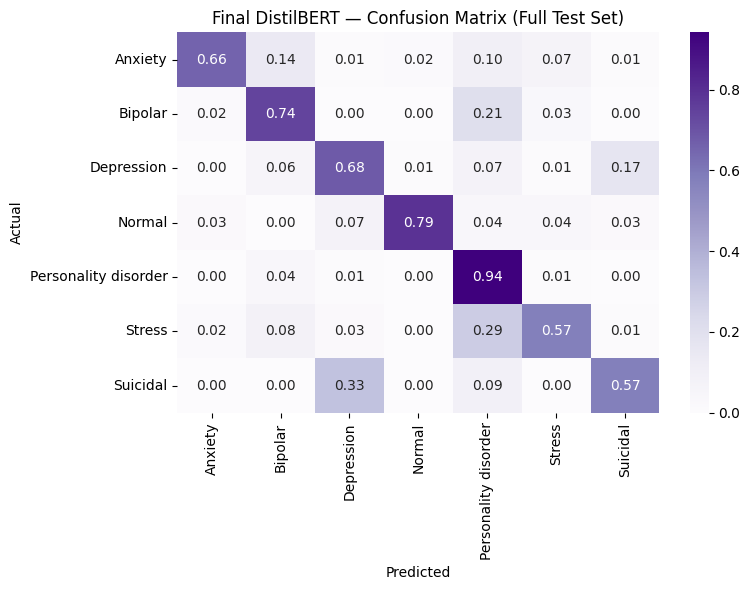

In [71]:
# ✅ 1. Tokenize the FULL test set
full_test_texts = test_df["statement"].tolist()
full_test_labels = test_df["status"].tolist()

full_test_tok = tok(full_test_texts, truncation=True, padding="max_length",
                    max_length=128, return_tensors="pt")

# ✅ 2. Predict in batches (to avoid memory issues)
model.eval()
pred_ids = []
for i in range(0, len(full_test_texts), 64):  # adjust batch size if needed
    batch = {k: v[i:i+64].to(model.device) for k, v in full_test_tok.items()}
    with torch.no_grad():
        logits = model(**batch).logits
    pred_ids.extend(logits.argmax(dim=-1).cpu().tolist())

pred_labels = [id2label[i] for i in pred_ids]
print(f"✅ Predictions complete: {len(pred_labels)} samples")

# ✅ 3. Confusion Matrix & Metrics
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np, os

labels_order = list(id2label.values())
cm = confusion_matrix(full_test_labels, pred_labels, labels=labels_order)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Purples",
            xticklabels=labels_order, yticklabels=labels_order)
plt.title("Final DistilBERT — Confusion Matrix (Full Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()

os.makedirs("/content/final_results", exist_ok=True)
plt.savefig("/content/final_results/confusion_matrix_full.png", dpi=300)

report = classification_report(full_test_labels, pred_labels,
                               labels=labels_order, output_dict=True)
pd.DataFrame(report).transpose().to_csv("/content/final_results/classification_report_full.csv")

print("✅ Full test-set evaluation complete!")
print("Confusion matrix + report saved to /content/final_results/")


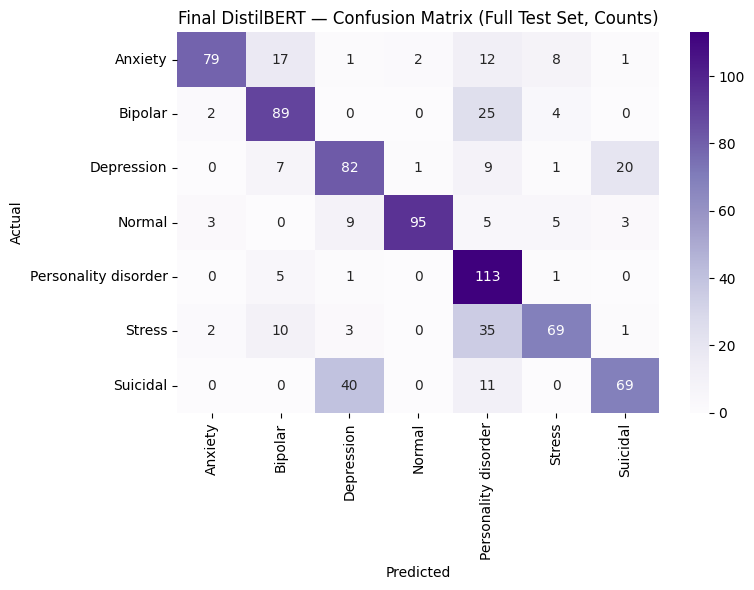

✅ Saved both confusion matrix and classification report in /content/final_results/


In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you already have:
# true_labels = list(test_df["status"])
# pred_labels = [id2label[i] for i in pred_ids]
# labels_order = list(id2label.values())

# 1️⃣ Raw confusion matrix (not normalized)
cm_counts = confusion_matrix(true_labels, pred_labels, labels=labels_order)

plt.figure(figsize=(8,6))
sns.heatmap(cm_counts, annot=True, fmt="d", cmap="Purples",
            xticklabels=labels_order, yticklabels=labels_order)
plt.title("Final DistilBERT — Confusion Matrix (Full Test Set, Counts)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()

# 2️⃣ Save high-resolution version
plt.savefig("/content/final_results/confusion_matrix_full_counts.png", dpi=400)
plt.show()

# 3️⃣ Save classification report too
report = classification_report(true_labels, pred_labels, labels=labels_order, output_dict=True)
pd.DataFrame(report).transpose().to_csv("/content/final_results/classification_report_full_counts.csv")

print("✅ Saved both confusion matrix and classification report in /content/final_results/")


In [ ]:
# -------------------------------------------------------------
# ✅ 1️⃣ Tokenize your ENTIRE dataset (53k statements)
# -------------------------------------------------------------
full_texts = df["statement"].astype(str).tolist()
full_labels = df["status"].astype(str).tolist()

from tqdm import tqdm
all_preds = []

model.eval()
batch_size = 64
for i in tqdm(range(0, len(full_texts), batch_size)):
    batch = full_texts[i:i+batch_size]
    toks = tok(batch, truncation=True, padding="max_length", max_length=128, return_tensors="pt").to(model.device)
    with torch.no_grad():
        logits = model(**toks).logits
    all_preds.extend(logits.argmax(dim=-1).cpu().tolist())

# map predictions to class names
pred_labels_full = [id2label[i] for i in all_preds]
print("✅ Done — total predictions:", len(pred_labels_full))

# -------------------------------------------------------------
# ✅ 2️⃣ Compute Confusion Matrix & Report
# -------------------------------------------------------------
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns, matplotlib.pyplot as plt, pandas as pd, numpy as np, os

labels_order = list(id2label.values())

cm_full = confusion_matrix(full_labels, pred_labels_full, labels=labels_order)

plt.figure(figsize=(9,7))
sns.heatmap(cm_full, annot=True, fmt="d", cmap="Purples",
            xticklabels=labels_order, yticklabels=labels_order)
plt.title("Final DistilBERT — Confusion Matrix (All 53K Data)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()

os.makedirs("/content/final_results", exist_ok=True)
plt.savefig("/content/final_results/confusion_matrix_full_53k.png", dpi=400)

report_full = classification_report(full_labels, pred_labels_full,
                                    labels=labels_order, output_dict=True)
pd.DataFrame(report_full).transpose().to_csv("/content/final_results/classification_report_full_53k.csv")

print("✅ Saved confusion matrix and full report in /content/final_results/")


 43%|████▎     | 358/827 [1:23:15<1:50:05, 14.08s/it]